# setup

In [1]:
import logging
logging.getLogger().setLevel(logging.ERROR) # suppress the SafeTensors loading messages

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%%capture
!pip install git+https://github.com/EleutherAI/sae.git

In [4]:
# you should load this before cloning repo files
# from .config import SaeConfig
# from .utils import decoder_impl

from sae.config import SaeConfig
from sae.utils import decoder_impl
from sae import Sae

Triton not installed, using eager implementation of SAE decoder.


In [5]:
import gc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
from fnmatch import fnmatch
from pathlib import Path
from typing import NamedTuple, Optional, Callable, Union, List, Tuple
# from jaxtyping import Float, Int

import einops
import torch
from torch import Tensor, nn
from huggingface_hub import snapshot_download
from natsort import natsorted
from safetensors.torch import load_model, save_model

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
from collections import Counter

## corr fns

In [7]:
def normalize_byChunks(actv_tensor, chunk_size=10000): # chunk_size: Number of rows per chunk
    mean_A = actv_tensor.mean(dim=0, keepdim=True)
    std_A = actv_tensor.std(dim=0, keepdim=True)

    num_chunks = actv_tensor.shape[0] // chunk_size

    normalized_A = np.zeros_like(actv_tensor.cpu())  # Preallocate the normalized matrix
    # normalized_A = actv_tensor.new_zeros(actv_tensor.size())

    for i in range(num_chunks):
        # print (i, num_chunks)
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        chunk = actv_tensor[start_index:end_index]
        normalized_A[start_index:end_index] = (chunk - mean_A) / (std_A + 1e-8)

    # Handle any remaining rows if the data size is not perfectly divisible by chunk_size
    if actv_tensor.shape[0] % chunk_size != 0:
        start_index = num_chunks * chunk_size
        chunk = actv_tensor[start_index:]
        normalized_A[start_index:] = (chunk - mean_A) / (std_A + 1e-8)

    return torch.tensor(normalized_A)

In [8]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    # if torch.cuda.is_available():
    #     reshaped_activations_A = reshaped_activations_A.to('cuda')
    #     reshaped_activations_B = reshaped_activations_B.to('cuda')

    normalized_A = normalize_byChunks(reshaped_activations_A, chunk_size=10000)
    normalized_B = normalize_byChunks(reshaped_activations_B, chunk_size=10000)

    if torch.cuda.is_available():
        normalized_A = normalized_A.to('cuda')
        normalized_B = normalized_B.to('cuda')

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        # if start % 5000 == 0:
        #     print(start)
        end = min(start + batch_size, normalized_B.shape[1])

        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    # return torch.cat(max_indices), torch.cat(max_values)
    return torch.cat(max_indices).cpu().numpy(), torch.cat(max_values).cpu().numpy()

## sim fns

In [9]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [10]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [11]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [12]:
import scipy.optimize

def permutation_procrustes(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    optimal_permutation_alignment: Optional[Tuple[npt.NDArray, npt.NDArray]] = None,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    R, Rp = adjust_dimensionality(R, Rp)

    if not optimal_permutation_alignment:
        PR, PRp = scipy.optimize.linear_sum_assignment(R.T @ Rp, maximize=True)  # returns column assignments
        optimal_permutation_alignment = (PR, PRp)
    PR, PRp = optimal_permutation_alignment
    return float(np.linalg.norm(R[:, PR] - Rp[:, PRp], ord="fro"))

In [13]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [14]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [15]:
def score_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    i = 0
    # for i in range(num_runs):
    while i < num_runs:
        try:
            rand_modA_feats = np.random.choice(range(weight_matrix_np.shape[0]), size=num_feats, replace=False).tolist()
            rand_modB_feats = np.random.choice(range(weight_matrix_2.shape[0]), size=num_feats, replace=False).tolist()

            if shapereq_bool:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
            else:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
            all_rand_scores.append(score)
            i += 1
        except:
            continue
    return sum(all_rand_scores) / len(all_rand_scores)

In [16]:
import random
def shuffle_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    for i in range(num_runs):
        row_idxs = list(range(num_feats))
        random.shuffle(row_idxs)
        if shapereq_bool:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs], "nd")
        else:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs])
        all_rand_scores.append(score)
    # return sum(all_rand_scores) / len(all_rand_scores)
    return all_rand_scores

## plot fns

In [17]:
def plot_svcca_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['svcca_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['svcca_rand_mean'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [18]:
def plot_rsa_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['rsa_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['rsa_rand_mean'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('RSA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [19]:
def plot_meanCorr_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr'] for i in range(0, 12)]
    # unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    # rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    # label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [20]:
def plot_meanCorr_filt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [21]:
def plot_numFeats_afterFilt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['num_feat_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Num Feats Kept')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [22]:
# def plot_js_byLayer(layer_to_dictscores):
#     for key, sub_dict in layer_to_dictscores.items():
#         for sub_key, value in sub_dict.items():
#             sub_dict[sub_key] = round(value, 4)

#     layers = [f'L{i}' for i in range(0, 12)]
#     paired_values = [layer_to_dictscores[i]['1-1 jaccard_paired'] for i in range(0, 12)]
#     unpaired_values = [layer_to_dictscores[i]['1-1 jaccard_unpaired'] for i in range(0, 12)]

#     # Plotting configuration
#     x = np.arange(len(layers))  # label locations
#     width = 0.35  # width of the bars

#     # Increase figure size
#     fig, ax = plt.subplots(figsize=(12, 7))  # Slightly increased figure size
#     rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
#     rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

#     # Adding labels, title and custom x-axis tick labels
#     ax.set_ylabel('Jaccard NN')
#     ax.set_title('SAEs comparison by Pythia 70m MLP0 vs 160m MLP Layers')
#     ax.set_xticks(x)
#     ax.set_xticklabels(layers)
#     ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
#     ax.legend()

#     # Label bars with increased font size and different positioning for paired and unpaired
#     def label_bars(rects, is_paired):
#         for rect in rects:
#             height = rect.get_height()
#             label_height = height + 0.05 if is_paired else height + 0.01
#             ax.text(rect.get_x() + rect.get_width()/2., label_height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)  # Increased font size to 12

#     label_bars(rects1, True)   # Paired bars
#     label_bars(rects2, False)  # Unpaired bars

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     # Increase y-axis limit to accommodate higher labels
#     ax.set_ylim(0, 1.1)  # Increased from 1 to 1.1

#     plt.show()

## interpret fns

In [23]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
): # -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [24]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = tokenizer.decode([batch_tokens[batch_idx, i].item()]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

In [25]:
def store_top_toks(top_acts_indices, top_acts_values, batch_tokens):
    feat_samps = []
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        new_str_token = tokenizer.decode(batch_tokens[batch_idx, seq_idx]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
        feat_samps.append(new_str_token)
    return feat_samps

## get llm actv fns

In [26]:
from torch.utils.data import DataLoader, TensorDataset

def get_llm_actvs_batch(model, inputs, layerID):
# def get_llm_actvs_batch(model, inputs, layerID, batch_size=100, maxseqlen=300):
# def get_llm_actvs_batch(model, inputs, batch_size=100, maxseqlen=300):
    # outputs_by_layer = {None for layerID in len(model.gpt_neox.layers)}
    accumulated_outputs = None
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    all_hidden_states = []
    for batch in loader:
        input_ids, attention_mask = batch

        batch_inputs = {'input_ids': input_ids.to(model.device), 'attention_mask': attention_mask.to(model.device)}
        with torch.no_grad():  # Disable gradient calculation for memory efficiency
            outputs = model(**batch_inputs, output_hidden_states=True)
            if accumulated_outputs is None:
                accumulated_outputs = outputs.hidden_states[layerID]
                # for layer_id in len(model.gpt_neox.layers):
                    # outputs_by_layer[layer_id] = outputs.hidden_states[layer_id]
            else:
                accumulated_outputs = torch.cat((accumulated_outputs, outputs.hidden_states[layerID]), dim= 0)

        del batch_inputs, outputs
        torch.cuda.empty_cache()
        gc.collect()

    return accumulated_outputs

## get sae actv fns

In [27]:
# def get_weights_and_acts(name, cfg_dict, layer_id, outputs):
def get_weights_and_acts(name, layer_id, outputs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    hookpoint = "layers." + str(layer_id)

    sae = Sae.load_from_hub(name, hookpoint=hookpoint, device=device)

    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        # reshaped_activations_A = sae.pre_acts(outputs.to("cuda"))
        # reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))
        orig = sae.pre_acts(outputs.to("cuda"))

    first_dim_reshaped = orig.shape[0] * orig.shape[1]
    reshaped_activations_A = orig.reshape(first_dim_reshaped, orig.shape[-1]).cpu()

    return weight_matrix_np, reshaped_activations_A, orig
    return weight_matrix_np, reshaped_activations_A

In [28]:
def get_weights_and_acts_byLayer(name, layer_id, outputs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    hookpoint = "layers." + str(layer_id)

    sae = Sae.load_from_hub(name, hookpoint=hookpoint, device=device)

    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        reshaped_activations_A = sae.pre_acts(outputs.to("cuda"))
        # reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
    reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

    return weight_matrix_np, reshaped_activations_A

In [29]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

## run expm fns

In [30]:
def run_expm(layer_id, outputs, outputs_2, layer_start, layer_end):
    layer_to_dictscores = {}

    name = "EleutherAI/sae-pythia-70m-32k"
    weight_matrix_np, reshaped_activations_A = get_weights_and_acts(name, layer_id, outputs)

    name = "EleutherAI/sae-pythia-160m-32k"
    for layerID_2 in range(layer_start, layer_end): # 0, 12
        dictscores = {}

        weight_matrix_2, reshaped_activations_B = get_weights_and_acts_byLayer(name, layerID_2, outputs_2)

        """
        `batched_correlation(reshaped_activations_B, reshaped_activations_A)`:
        highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals.
        Use the list with smaller number of features (cols) as the second arg
        """
        highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)

        # num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
        # print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

        dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

        ###########
        # filter

        sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
        # kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]
        kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]

        filt_corr_ind_A = []
        filt_corr_ind_B = []
        seen = set()
        for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
            if ind_A in kept_modA_feats:
                filt_corr_ind_A.append(ind_A)
                filt_corr_ind_B.append(ind_B)
            elif ind_A not in seen:  # only keep one if it's over count X
                seen.add(ind_A)
                filt_corr_ind_A.append(ind_A)
                filt_corr_ind_B.append(ind_B)
        # num_unq_pairs = len(list(set(filt_corr_ind_A)))
        # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
        # print("num feats after filt: ", len(filt_corr_ind_A))

        new_highest_correlations_indices_A = []
        new_highest_correlations_indices_B = []
        new_highest_correlations_values = []

        for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
            val = highest_correlations_values_AB[ind_B]
            if val > 0:
                new_highest_correlations_indices_A.append(ind_A)
                new_highest_correlations_indices_B.append(ind_B)
                new_highest_correlations_values.append(val)

        # print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
        # print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
        dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

        dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

        ###########
        # sim tests

        num_feats = len(new_highest_correlations_indices_A)
        num_runs = 100

        dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

        rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                                    weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                    svcca, shapereq_bool=True)
        dictscores["svcca_rand_mean"] = sum(rand_scores) / len(rand_scores)
        dictscores["svcca_rand_pval"] =  np.mean(np.array(rand_scores) >= dictscores["svcca_paired"])

        dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
        rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                                                    weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                                    representational_similarity_analysis, shapereq_bool=True)
        dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)
        dictscores["rsa_rand_pval"] =  np.mean(np.array(rand_scores) >= dictscores["rsa_paired"])

        print("Layer: " + str(layerID_2))
        for key, value in dictscores.items():
            print(key + ": " + str(value))
        print("\n")

        layer_to_dictscores[layerID_2] = dictscores
    return layer_to_dictscores

# load data

In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
from datasets import load_dataset
# dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True)

openwebtext.py:   0%|          | 0.00/2.73k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [33]:
batch_size = 100
maxseqlen = 300

def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter, batch_size)

# Tokenize the batch
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

# load models

In [34]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
model_2 = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m")

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

# res stream 2 v 5

In [ ]:
layerID = 2
layer_id_2 = 5

## get llm actvs

In [ ]:
with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layerID)

In [ ]:
with torch.inference_mode():
    outputs_2 = get_llm_actvs_batch(model_2, inputs, layer_id_2)

## load sae

In [ ]:
name = "EleutherAI/sae-pythia-70m-32k"
weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(name, layerID, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
name = "EleutherAI/sae-pythia-160m-32k"
weight_matrix_2, reshaped_activations_B, feature_acts_model_B = get_weights_and_acts(name, layer_id_2, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## corrs

In [ ]:
dictscores = {}

In [ ]:
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.202484130859375


0.6979668723586201

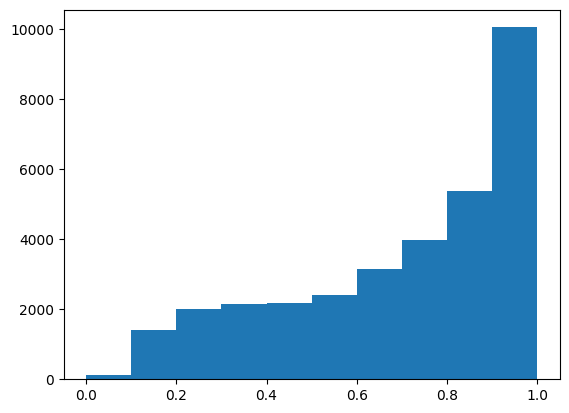

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  16337 | Count:  4862 | Corr:  0.808744
FeatID:  2604 | Count:  3925 | Corr:  0.28739166
FeatID:  32352 | Count:  2670 | Corr:  0.8703611
FeatID:  32697 | Count:  2287 | Corr:  0.16548711
FeatID:  21787 | Count:  1809 | Corr:  0.5346916
FeatID:  13328 | Count:  850 | Corr:  0.39243227
FeatID:  11415 | Count:  781 | Corr:  0.34609118
FeatID:  28639 | Count:  460 | Corr:  0.36947736
FeatID:  12313 | Count:  349 | Corr:  0.773475
FeatID:  15282 | Count:  248 | Corr:  0.94138145
FeatID:  12813 | Count:  228 | Corr:  0.95818466
FeatID:  3128 | Count:  172 | Corr:  0.94228363
FeatID:  7120 | Count:  170 | Corr:  0.26409584
FeatID:  7318 | Count:  164 | Corr:  0.7944792
FeatID:  32565 | Count:  105 | Corr:  0.89276236
FeatID:  24468 | Count:  98 | Corr:  0.9643394
FeatID:  1182 | Count:  74 | Corr:  0.84594357
FeatID:  1172 | Count:  58 | Corr:  0.9206029
FeatID:  18972 | Count:  55 | Corr:  0.43633988
FeatID:  16722 | Count:  55 | Corr:  0.900549


## interpret

In [ ]:
sorted_feat_counts[0][0]

16337

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  16337


batchID: 21, Act = 1.48, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 1.47, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 39, Act = 1.47, Seq = " August, police have said.\n\nThe 28"
batchID: 27, Act = 1.46, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 44, Act = 1.46, Seq = " tale of New Jersey politics. So it is only"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 4862
Correlation: 0.939940869808197
Model A Feature:  16337


batchID: 21, Act = 1.48, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 1.47, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 39, Act = 1.47, Seq = " August, police have said.\n\nThe 28"
batchID: 27, Act = 1.46, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 44, Act = 1.46, Seq = " tale of New Jersey politics. So it is only"

Model B Feature:  32761


batchID: 89, Act = 0.95, Seq = "s most iconic arenas. It’s played"
batchID: 28, Act = 0.93, Seq = " economic reality that surrounds us. This leads to a"
batchID: 16, Act = 0.91, Seq = " the global extortion campaign.\n\nA man"
batchID: 34, Act = 0.91, Seq = " virtually nothing but a lawsuit.\n\nThe Hig"
batchID: 26, Act = 0.88, Seq = "” that costs $450. In this post I"

--------------------------------------------------
Count: 3925
Correlation: 0.8527119755744934
Model A Feature:  2604


batchID: 33, Act = 2.93, Seq = " the course of four days. Here’s pre"
batchID: 21, Act = 2.85, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 2.73, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 27, Act = 2.68, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 37, Act = 2.66, Seq = "Executive summary\n\nThis paper reviews"

Model B Feature:  32764


batchID: 53, Act = 0.88, Seq = " in four districts of Punjab.\n\nThree companies"
batchID: 41, Act = 0.86, Seq = " contract he did not sign. Although not specifically named"
batchID: 96, Act = 0.85, Seq = " loose with a few expletives.\n\n"
batchID: 32, Act = 0.81, Seq = "ivas Guadalajara.\n\nAdams"
batchID: 56, Act = 0.79, Seq = "’t know for sure. But the trackers"

--------------------------------------------------
Count: 2670
Correlation: 0.9436706900596619
Model A Feature:  32352


batchID: 37, Act = 1.73, Seq = "Executive summary\n\nThis paper reviews"
batchID: 33, Act = 1.37, Seq = " the course of four days. Here’s pre"
batchID: 69, Act = 1.37, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 27, Act = 1.28, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 49, Act = 1.28, Seq = " arm prepared for minor surgery. (Print by Abraham"

Model B Feature:  32750


batchID: 1, Act = 1.14, Seq = " a campaign rally in St. Louis on Saturday."
batchID: 55, Act = 1.05, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 80, Act = 1.04, Seq = " China last Saturday (5.7.2014)"
batchID: 60, Act = 1.02, Seq = "FILE - In this Dec. 17, 2015,"
batchID: 83, Act = 1.01, Seq = " Air Canada and WestJet.\n\n"We"

--------------------------------------------------
Count: 2287
Correlation: 0.9508575797080994
Model A Feature:  32697


batchID: 37, Act = 6.41, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 5.48, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 77, Act = 5.27, Seq = " is over 7 years old\n\nMajor rights holders"
batchID: 49, Act = 5.05, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 56, Act = 4.95, Seq = "’t know for sure. But the trackers"

Model B Feature:  32766


batchID: 6, Act = 1.74, Seq = " but others decided against it\n\nSEATTLE"
batchID: 42, Act = 1.71, Seq = " heart, a study shows\n\nPeople who have"
batchID: 23, Act = 1.69, Seq = "Introduction\n\nOn Feb."
batchID: 47, Act = 1.67, Seq = " us sad By Mike Priest\n\nDouble charges,"
batchID: 20, Act = 1.63, Seq = " than £150,000\n\nThe Liberal Democrats"

--------------------------------------------------
Count: 1809
Correlation: 0.8609442710876465
Model A Feature:  21787


batchID: 37, Act = 3.90, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 2.78, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 56, Act = 2.66, Seq = "’t know for sure. But the trackers"
batchID: 72, Act = 2.56, Seq = " his phone, when Coun. Matthew Green was stopped"
batchID: 77, Act = 2.54, Seq = " is over 7 years old\n\nMajor rights holders"

Model B Feature:  32741


batchID: 1, Act = 0.83, Seq = " a campaign rally in St. Louis on Saturday."
batchID: 99, Act = 0.73, Seq = "”. In simulating any complex system, any model"
batchID: 91, Act = 0.54, Seq = "4 per cent fall in real consumer spending per household"
batchID: 23, Act = 0.51, Seq = "Introduction\n\nOn Feb."
batchID: 42, Act = 0.49, Seq = " heart, a study shows\n\nPeople who have"

--------------------------------------------------


## rmv junk features v2

In [ ]:
dictscores = {}
samp_m = 5

sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100000]

junk_words = ['.', ' \n', ' ', '-' , '<bos>', ',', '!', '?']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.5278926774734488
num feats after filt:  8945


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.5827835366521245

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.013604606252551612

## rmv featues without common kw AND junk

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', ' \n', ' ', '-' , '<bos>', ',', '!', '?']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.5868392664509169
num feats after filt:  7416


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.6061552824613525

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.013604606252551612

# res stream 3 v 5

In [ ]:
layerID = 3
layer_id_2 = 5

## get llm actvs

In [ ]:
with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layerID)

In [ ]:
with torch.inference_mode():
    outputs_2 = get_llm_actvs_batch(model_2, inputs, layer_id_2)

## load sae

In [ ]:
name = "EleutherAI/sae-pythia-70m-32k"
weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(name, layerID, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
name = "EleutherAI/sae-pythia-160m-32k"
weight_matrix_2, reshaped_activations_B, feature_acts_model_B = get_weights_and_acts(name, layer_id_2, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## corrs

In [ ]:
dictscores = {}

In [ ]:
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.19976806640625


0.6982761515196216

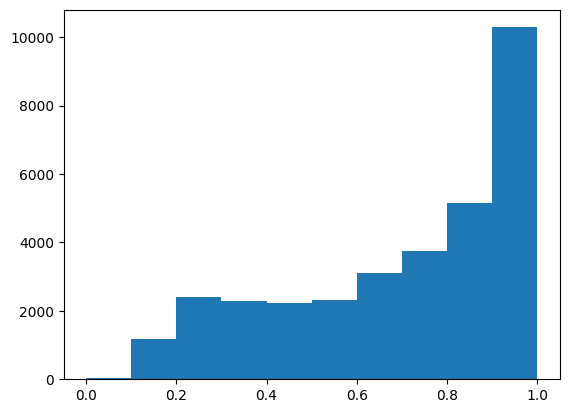

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  1761 | Count:  13839 | Corr:  0.60785484
FeatID:  2033 | Count:  3779 | Corr:  0.7323965
FeatID:  28285 | Count:  1643 | Corr:  0.29538196
FeatID:  20459 | Count:  286 | Corr:  0.80956376
FeatID:  30498 | Count:  215 | Corr:  0.8577569
FeatID:  609 | Count:  139 | Corr:  0.9521664
FeatID:  503 | Count:  87 | Corr:  0.33560613
FeatID:  16716 | Count:  65 | Corr:  0.9677688
FeatID:  23533 | Count:  63 | Corr:  0.64271635
FeatID:  18306 | Count:  59 | Corr:  0.34438848
FeatID:  5900 | Count:  59 | Corr:  0.2520127
FeatID:  8676 | Count:  56 | Corr:  0.84892344
FeatID:  9161 | Count:  56 | Corr:  0.9658968
FeatID:  3341 | Count:  55 | Corr:  0.2726006
FeatID:  25033 | Count:  53 | Corr:  0.67516935
FeatID:  30873 | Count:  47 | Corr:  0.9336773
FeatID:  23241 | Count:  44 | Corr:  0.10916109
FeatID:  25355 | Count:  42 | Corr:  0.8188202
FeatID:  110 | Count:  40 | Corr:  0.9595902
FeatID:  29073 | Count:  39 | Corr:  0.3513886


## interpret

In [ ]:
sorted_feat_counts[0][0]

1761

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  1761


batchID: 55, Act = 1.01, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 5, Act = 0.91, Seq = " to nine months in jail. Eric Brazau"
batchID: 49, Act = 0.89, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 13, Act = 0.89, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 39, Act = 0.88, Seq = " August, police have said.\n\nThe 28"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 13839
Correlation: 0.5129868984222412
Model A Feature:  1761


batchID: 55, Act = 1.01, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 5, Act = 0.91, Seq = " to nine months in jail. Eric Brazau"
batchID: 49, Act = 0.89, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 13, Act = 0.89, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 39, Act = 0.88, Seq = " August, police have said.\n\nThe 28"

Model B Feature:  32765


batchID: 39, Act = 1.17, Seq = " killed a cyclist just outside the Olympic Park in"
batchID: 39, Act = 1.09, Seq = "s had been arrested just outside the Olympic Park at"
batchID: 11, Act = 1.00, Seq = " there’s measuring the drapes on a house"
batchID: 11, Act = 0.86, Seq = "There’s measuring the drapes, and then"
batchID: 56, Act = 0.84, Seq = "’t seen the moose for several hours."

--------------------------------------------------
Count: 3779
Correlation: 0.9683617949485779
Model A Feature:  2033


batchID: 37, Act = 9.19, Seq = "Executive summary\n\nThis paper reviews"
batchID: 59, Act = 8.94, Seq = " Riot Jynx\n\nCheck out the"
batchID: 48, Act = 8.90, Seq = " Help Out New Pal China\n\nIsrael is a"
batchID: 82, Act = 8.53, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 88, Act = 8.51, Seq = " Print Mail Flipboard\n\nLibertarian"

Model B Feature:  32766


batchID: 6, Act = 1.74, Seq = " but others decided against it\n\nSEATTLE"
batchID: 42, Act = 1.71, Seq = " heart, a study shows\n\nPeople who have"
batchID: 23, Act = 1.69, Seq = "Introduction\n\nOn Feb."
batchID: 47, Act = 1.67, Seq = " us sad By Mike Priest\n\nDouble charges,"
batchID: 20, Act = 1.63, Seq = " than £150,000\n\nThe Liberal Democrats"

--------------------------------------------------
Count: 1643
Correlation: 0.5525161623954773
Model A Feature:  28285


batchID: 13, Act = 3.15, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 33, Act = 3.07, Seq = " the course of four days. Here’s pre"
batchID: 49, Act = 3.00, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 5, Act = 2.98, Seq = " to nine months in jail. Eric Brazau"
batchID: 56, Act = 2.98, Seq = "’t know for sure. But the trackers"

Model B Feature:  32762


batchID: 57, Act = 0.57, Seq = "\n\n"Taiwan's democracy and Hong"
batchID: 65, Act = 0.56, Seq = " town of Auckland, New Zealand director Sam Raim"
batchID: 52, Act = 0.49, Seq = " Kinnock in signing this letter were ministers under"
batchID: 52, Act = 0.46, Seq = " letter in support of the EU in the Sunday Mirror"
batchID: 52, Act = 0.46, Seq = "’s relationship with the EU, they write:"

--------------------------------------------------
Count: 286
Correlation: 0.7025490999221802
Model A Feature:  20459


batchID: 46, Act = 3.37, Seq = "From WikiFur,"
batchID: 59, Act = 3.36, Seq = " Riot Jynx\n\nCheck out the"
batchID: 97, Act = 3.20, Seq = " approximately 07:13 a.m., the Co"
batchID: 59, Act = 3.15, Seq = "By Riot Jyn"
batchID: 96, Act = 3.12, Seq = "On a third-down"

Model B Feature:  32450


batchID: 84, Act = 1.27, Seq = "Last month, the Seattle"
batchID: 48, Act = 1.08, Seq = "Israel Accused of Supp"
batchID: 3, Act = 0.97, Seq = "BIGBANG is"
batchID: 31, Act = 0.84, Seq = "Breaking News Emails"
batchID: 24, Act = 0.82, Seq = " Arkansas this morning and moved northeast to Illinois this afternoon"

--------------------------------------------------
Count: 215
Correlation: 0.8757634162902832
Model A Feature:  30498


batchID: 37, Act = 11.99, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 11.00, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 95, Act = 10.62, Seq = "ST. LOUIS —"
batchID: 59, Act = 10.38, Seq = " Riot Jynx\n\nCheck out the"
batchID: 77, Act = 10.33, Seq = " is over 7 years old\n\nMajor rights holders"

Model B Feature:  32276


batchID: 98, Act = 1.46, Seq = "Ultra-loved"
batchID: 7, Act = 1.18, Seq = "Today, Toyota announced changes"
batchID: 89, Act = 0.92, Seq = "s most iconic arenas. It’s played"
batchID: 13, Act = 0.90, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 36, Act = 0.88, Seq = " to appear and observe proceedings. In the Marvel Universe"

--------------------------------------------------


## rmv junk features v2

In [ ]:
dictscores = {}
samp_m = 5

sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100000]

junk_words = ['.', ' \n', ' ', '-' , '<bos>', ',', '!', '?']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.43594049904030713
num feats after filt:  12504


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.06376361749749336

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.006845392811001786

## rmv featues without common kw AND junk

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', ' \n', ' ', '-' , '<bos>', ',', '!', '?']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.49124360487996854
num feats after filt:  10164


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.10181914543094396

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.008171779583592916

### interpret why svcca low

In [ ]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  2033 | Count:  1535 | Corr:  0.7323965
FeatID:  18306 | Count:  55 | Corr:  0.34438848
FeatID:  609 | Count:  52 | Corr:  0.9521664
FeatID:  30873 | Count:  45 | Corr:  0.9336773
FeatID:  23241 | Count:  44 | Corr:  0.10916109
FeatID:  8676 | Count:  33 | Corr:  0.84892344
FeatID:  110 | Count:  30 | Corr:  0.9595902
FeatID:  25316 | Count:  23 | Corr:  0.74514955
FeatID:  15618 | Count:  23 | Corr:  0.9703657
FeatID:  3433 | Count:  22 | Corr:  0.72272736
FeatID:  16480 | Count:  21 | Corr:  0.9013241
FeatID:  1806 | Count:  19 | Corr:  0.7639227
FeatID:  9601 | Count:  18 | Corr:  0.73113525
FeatID:  7562 | Count:  17 | Corr:  0.7619499
FeatID:  10632 | Count:  17 | Corr:  0.7194258
FeatID:  2400 | Count:  16 | Corr:  0.6404934
FeatID:  27303 | Count:  16 | Corr:  0.9779537
FeatID:  32139 | Count:  16 | Corr:  0.24512741
FeatID:  16300 | Count:  16 | Corr:  0.84759635
FeatID:  19691 | Count:  15 | Corr:  0.14456081


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  2033


batchID: 37, Act = 9.19, Seq = "Executive summary\n\nThis paper reviews"
batchID: 59, Act = 8.94, Seq = " Riot Jynx\n\nCheck out the"
batchID: 48, Act = 8.90, Seq = " Help Out New Pal China\n\nIsrael is a"
batchID: 82, Act = 8.53, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 88, Act = 8.51, Seq = " Print Mail Flipboard\n\nLibertarian"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 13839
Correlation: 0.5129868984222412
Model A Feature:  1761


batchID: 55, Act = 1.01, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 5, Act = 0.91, Seq = " to nine months in jail. Eric Brazau"
batchID: 49, Act = 0.89, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 13, Act = 0.89, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 39, Act = 0.88, Seq = " August, police have said.\n\nThe 28"

Model B Feature:  32765


batchID: 39, Act = 1.17, Seq = " killed a cyclist just outside the Olympic Park in"
batchID: 39, Act = 1.09, Seq = "s had been arrested just outside the Olympic Park at"
batchID: 11, Act = 1.00, Seq = " there’s measuring the drapes on a house"
batchID: 11, Act = 0.86, Seq = "There’s measuring the drapes, and then"
batchID: 56, Act = 0.84, Seq = "’t seen the moose for several hours."

--------------------------------------------------
Count: 3779
Correlation: 0.9683617949485779
Model A Feature:  2033


batchID: 37, Act = 9.19, Seq = "Executive summary\n\nThis paper reviews"
batchID: 59, Act = 8.94, Seq = " Riot Jynx\n\nCheck out the"
batchID: 48, Act = 8.90, Seq = " Help Out New Pal China\n\nIsrael is a"
batchID: 82, Act = 8.53, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 88, Act = 8.51, Seq = " Print Mail Flipboard\n\nLibertarian"

Model B Feature:  32766


batchID: 6, Act = 1.74, Seq = " but others decided against it\n\nSEATTLE"
batchID: 42, Act = 1.71, Seq = " heart, a study shows\n\nPeople who have"
batchID: 23, Act = 1.69, Seq = "Introduction\n\nOn Feb."
batchID: 47, Act = 1.67, Seq = " us sad By Mike Priest\n\nDouble charges,"
batchID: 20, Act = 1.63, Seq = " than £150,000\n\nThe Liberal Democrats"

--------------------------------------------------
Count: 1643
Correlation: 0.5525161623954773
Model A Feature:  28285


batchID: 13, Act = 3.15, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 33, Act = 3.07, Seq = " the course of four days. Here’s pre"
batchID: 49, Act = 3.00, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 5, Act = 2.98, Seq = " to nine months in jail. Eric Brazau"
batchID: 56, Act = 2.98, Seq = "’t know for sure. But the trackers"

Model B Feature:  32762


batchID: 57, Act = 0.57, Seq = "\n\n"Taiwan's democracy and Hong"
batchID: 65, Act = 0.56, Seq = " town of Auckland, New Zealand director Sam Raim"
batchID: 52, Act = 0.49, Seq = " Kinnock in signing this letter were ministers under"
batchID: 52, Act = 0.46, Seq = " letter in support of the EU in the Sunday Mirror"
batchID: 52, Act = 0.46, Seq = "’s relationship with the EU, they write:"

--------------------------------------------------
Count: 286
Correlation: 0.7025490999221802
Model A Feature:  20459


batchID: 46, Act = 3.37, Seq = "From WikiFur,"
batchID: 59, Act = 3.36, Seq = " Riot Jynx\n\nCheck out the"
batchID: 97, Act = 3.20, Seq = " approximately 07:13 a.m., the Co"
batchID: 59, Act = 3.15, Seq = "By Riot Jyn"
batchID: 96, Act = 3.12, Seq = "On a third-down"

Model B Feature:  32450


batchID: 84, Act = 1.27, Seq = "Last month, the Seattle"
batchID: 48, Act = 1.08, Seq = "Israel Accused of Supp"
batchID: 3, Act = 0.97, Seq = "BIGBANG is"
batchID: 31, Act = 0.84, Seq = "Breaking News Emails"
batchID: 24, Act = 0.82, Seq = " Arkansas this morning and moved northeast to Illinois this afternoon"

--------------------------------------------------
Count: 215
Correlation: 0.8757634162902832
Model A Feature:  30498


batchID: 37, Act = 11.99, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 11.00, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 95, Act = 10.62, Seq = "ST. LOUIS —"
batchID: 59, Act = 10.38, Seq = " Riot Jynx\n\nCheck out the"
batchID: 77, Act = 10.33, Seq = " is over 7 years old\n\nMajor rights holders"

Model B Feature:  32276


batchID: 98, Act = 1.46, Seq = "Ultra-loved"
batchID: 7, Act = 1.18, Seq = "Today, Toyota announced changes"
batchID: 89, Act = 0.92, Seq = "s most iconic arenas. It’s played"
batchID: 13, Act = 0.90, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 36, Act = 0.88, Seq = " to appear and observe proceedings. In the Marvel Universe"

--------------------------------------------------


## rmv featues junk, space agnostic

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\n', '', ' ', '-' , '<bos>', ',', '!', '?']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.4913197869402249
num feats after filt:  10138


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.10255268595447875

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.006561346138025947

### interpret why svcca low

In [ ]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  2033 | Count:  1534 | Corr:  0.7323965
FeatID:  18306 | Count:  55 | Corr:  0.34438848
FeatID:  609 | Count:  52 | Corr:  0.9521664
FeatID:  30873 | Count:  45 | Corr:  0.9336773
FeatID:  23241 | Count:  44 | Corr:  0.10916109
FeatID:  8676 | Count:  33 | Corr:  0.84892344
FeatID:  110 | Count:  30 | Corr:  0.9595902
FeatID:  25316 | Count:  23 | Corr:  0.74514955
FeatID:  15618 | Count:  23 | Corr:  0.9703657
FeatID:  3433 | Count:  22 | Corr:  0.72272736
FeatID:  16480 | Count:  21 | Corr:  0.9013241
FeatID:  1806 | Count:  19 | Corr:  0.7639227
FeatID:  9601 | Count:  18 | Corr:  0.73113525
FeatID:  7562 | Count:  17 | Corr:  0.7619499
FeatID:  10632 | Count:  17 | Corr:  0.7194258
FeatID:  2400 | Count:  16 | Corr:  0.6404934
FeatID:  27303 | Count:  16 | Corr:  0.9779537
FeatID:  32139 | Count:  16 | Corr:  0.24512741
FeatID:  16300 | Count:  16 | Corr:  0.84759635
FeatID:  19691 | Count:  15 | Corr:  0.14456081


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  2033


batchID: 37, Act = 9.19, Seq = "Executive summary\n\nThis paper reviews"
batchID: 59, Act = 8.94, Seq = " Riot Jynx\n\nCheck out the"
batchID: 48, Act = 8.90, Seq = " Help Out New Pal China\n\nIsrael is a"
batchID: 82, Act = 8.53, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 88, Act = 8.51, Seq = " Print Mail Flipboard\n\nLibertarian"

In [ ]:
feat_A = 2033
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
top_A_labels

['\\n', '\\n', '\\n', '\\n', '\\n']

In [ ]:
top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

In [ ]:
top_A_labels

['\\n', '\\n', '\\n', '\\n', '\\n']

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 1534
Correlation: 0.9683617949485779
Model A Feature:  2033


batchID: 37, Act = 9.19, Seq = "Executive summary\n\nThis paper reviews"
batchID: 59, Act = 8.94, Seq = " Riot Jynx\n\nCheck out the"
batchID: 48, Act = 8.90, Seq = " Help Out New Pal China\n\nIsrael is a"
batchID: 82, Act = 8.53, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 88, Act = 8.51, Seq = " Print Mail Flipboard\n\nLibertarian"

Model B Feature:  32766


batchID: 6, Act = 1.74, Seq = " but others decided against it\n\nSEATTLE"
batchID: 42, Act = 1.71, Seq = " heart, a study shows\n\nPeople who have"
batchID: 23, Act = 1.69, Seq = "Introduction\n\nOn Feb."
batchID: 47, Act = 1.67, Seq = " us sad By Mike Priest\n\nDouble charges,"
batchID: 20, Act = 1.63, Seq = " than £150,000\n\nThe Liberal Democrats"

--------------------------------------------------
Count: 55
Correlation: 0.48853713274002075
Model A Feature:  18306


batchID: 48, Act = 1.07, Seq = "Israel Accused of Supp"
batchID: 93, Act = 0.60, Seq = "Corporations And Govern"
batchID: 0, Act = 0.44, Seq = "Port-au-Prince"
batchID: 90, Act = 0.25, Seq = "rate you.\n\nOur expert: Dietitian"
batchID: 15, Act = 0.22, Seq = " You can read our Privacy Policy here. Sign up"

Model B Feature:  32677


batchID: 48, Act = 1.53, Seq = "Israel Accused of Supp"
batchID: 10, Act = 0.78, Seq = "Story highlights Tyka Nelson"
batchID: 7, Act = 0.74, Seq = "Today, Toyota announced changes"
batchID: 81, Act = 0.59, Seq = "Day two of Government Shut"
batchID: 41, Act = 0.57, Seq = "Shortly after the report ran on this site,"

--------------------------------------------------
Count: 52
Correlation: 0.6022807359695435
Model A Feature:  609


batchID: 93, Act = 22.57, Seq = "Corporations And Govern"
batchID: 86, Act = 20.94, Seq = "Recently, education reporter Jay"
batchID: 0, Act = 20.52, Seq = "Port-au-Prince"
batchID: 76, Act = 20.32, Seq = "JERUSALEM"
batchID: 48, Act = 20.17, Seq = "Israel Accused of Supp"

Model B Feature:  32598


batchID: 32, Act = 1.35, Seq = "New York Red Bulls Home"
batchID: 90, Act = 1.11, Seq = "Fact Buster\n\n"
batchID: 84, Act = 1.08, Seq = "Last month, the Seattle"
batchID: 37, Act = 1.06, Seq = "Executive summary\n\n"
batchID: 7, Act = 0.99, Seq = "Today, Toyota announced changes"

--------------------------------------------------
Count: 45
Correlation: 0.513205349445343
Model A Feature:  30873


batchID: 98, Act = 1.25, Seq = "Ultra-loved"
batchID: 53, Act = 0.47, Seq = " deployed in districts of Amritsar, Ludh"
batchID: 27, Act = 0.27, Seq = " closed more than 200 points higher Thursday, as Wall"
batchID: 79, Act = 0.24, Seq = " January.\n\nBRENDAN SMIAL"
batchID: 76, Act = 0.23, Seq = " was unprecedented, and the relatively light penalty handed down"

Model B Feature:  32613


batchID: 98, Act = 1.44, Seq = "Ultra-loved"
batchID: 48, Act = 0.96, Seq = "Israel Accused of Supp"
batchID: 52, Act = 0.61, Seq = "Five Labour grandees,"
batchID: 84, Act = 0.46, Seq = " made of rope and bike tires were "extreme"
batchID: 75, Act = 0.45, Seq = ", and Russell Wilson are among the celebrities"

--------------------------------------------------
Count: 44
Correlation: 0.7956822514533997
Model A Feature:  23241


batchID: 86, Act = 0.84, Seq = "Recently, education reporter Jay"
batchID: 48, Act = 0.58, Seq = "Israel Accused of Supp"
batchID: 7, Act = 0.24, Seq = "Today, Toyota announced changes"
batchID: 63, Act = 0.20, Seq = " Plays Pop, in which teams of children"
batchID: 96, Act = 0.16, Seq = " individual drills.\n\n“It was our first"

Model B Feature:  32550


batchID: 86, Act = 0.66, Seq = "Recently, education reporter Jay"
batchID: 48, Act = 0.62, Seq = "Israel Accused of Supp"
batchID: 1, Act = 0.32, Seq = "Former secretary of state Hillary"
batchID: 50, Act = 0.28, Seq = "After each mass shooting,"
batchID: 74, Act = 0.24, Seq = "President Trump with Health and"

--------------------------------------------------


## rmv junk \\n

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.5822662478859628
num feats after filt:  8278


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.5948683596914197

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.014865393703810468

### interpret

In [ ]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  18306 | Count:  53 | Corr:  0.34438848
FeatID:  609 | Count:  52 | Corr:  0.9521664
FeatID:  30873 | Count:  44 | Corr:  0.9336773
FeatID:  23241 | Count:  43 | Corr:  0.10916109
FeatID:  8676 | Count:  33 | Corr:  0.84892344
FeatID:  110 | Count:  30 | Corr:  0.9595902
FeatID:  25316 | Count:  23 | Corr:  0.74514955
FeatID:  15618 | Count:  23 | Corr:  0.9703657
FeatID:  3433 | Count:  22 | Corr:  0.72272736
FeatID:  16480 | Count:  21 | Corr:  0.9013241
FeatID:  1806 | Count:  19 | Corr:  0.7639227
FeatID:  10632 | Count:  17 | Corr:  0.7194258
FeatID:  9601 | Count:  17 | Corr:  0.73113525
FeatID:  27303 | Count:  16 | Corr:  0.9779537
FeatID:  32139 | Count:  16 | Corr:  0.24512741
FeatID:  16300 | Count:  16 | Corr:  0.84759635
FeatID:  2400 | Count:  15 | Corr:  0.6404934
FeatID:  19691 | Count:  15 | Corr:  0.14456081
FeatID:  7562 | Count:  15 | Corr:  0.7619499
FeatID:  28899 | Count:  15 | Corr:  0.972721


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  18306


batchID: 48, Act = 1.07, Seq = "Israel Accused of Supp"
batchID: 93, Act = 0.60, Seq = "Corporations And Govern"
batchID: 0, Act = 0.44, Seq = "Port-au-Prince"
batchID: 90, Act = 0.25, Seq = "rate you.\n\nOur expert: Dietitian"
batchID: 15, Act = 0.22, Seq = " You can read our Privacy Policy here. Sign up"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 53
Correlation: 0.48853713274002075
Model A Feature:  18306


batchID: 48, Act = 1.07, Seq = "Israel Accused of Supp"
batchID: 93, Act = 0.60, Seq = "Corporations And Govern"
batchID: 0, Act = 0.44, Seq = "Port-au-Prince"
batchID: 90, Act = 0.25, Seq = "rate you.\n\nOur expert: Dietitian"
batchID: 15, Act = 0.22, Seq = " You can read our Privacy Policy here. Sign up"

Model B Feature:  32677


batchID: 48, Act = 1.53, Seq = "Israel Accused of Supp"
batchID: 10, Act = 0.78, Seq = "Story highlights Tyka Nelson"
batchID: 7, Act = 0.74, Seq = "Today, Toyota announced changes"
batchID: 81, Act = 0.59, Seq = "Day two of Government Shut"
batchID: 41, Act = 0.57, Seq = "Shortly after the report ran on this site,"

--------------------------------------------------
Count: 52
Correlation: 0.6022807359695435
Model A Feature:  609


batchID: 93, Act = 22.57, Seq = "Corporations And Govern"
batchID: 86, Act = 20.94, Seq = "Recently, education reporter Jay"
batchID: 0, Act = 20.52, Seq = "Port-au-Prince"
batchID: 76, Act = 20.32, Seq = "JERUSALEM"
batchID: 48, Act = 20.17, Seq = "Israel Accused of Supp"

Model B Feature:  32598


batchID: 32, Act = 1.35, Seq = "New York Red Bulls Home"
batchID: 90, Act = 1.11, Seq = "Fact Buster\n\n"
batchID: 84, Act = 1.08, Seq = "Last month, the Seattle"
batchID: 37, Act = 1.06, Seq = "Executive summary\n\n"
batchID: 7, Act = 0.99, Seq = "Today, Toyota announced changes"

--------------------------------------------------
Count: 44
Correlation: 0.513205349445343
Model A Feature:  30873


batchID: 98, Act = 1.25, Seq = "Ultra-loved"
batchID: 53, Act = 0.47, Seq = " deployed in districts of Amritsar, Ludh"
batchID: 27, Act = 0.27, Seq = " closed more than 200 points higher Thursday, as Wall"
batchID: 79, Act = 0.24, Seq = " January.\n\nBRENDAN SMIAL"
batchID: 76, Act = 0.23, Seq = " was unprecedented, and the relatively light penalty handed down"

Model B Feature:  32613


batchID: 98, Act = 1.44, Seq = "Ultra-loved"
batchID: 48, Act = 0.96, Seq = "Israel Accused of Supp"
batchID: 52, Act = 0.61, Seq = "Five Labour grandees,"
batchID: 84, Act = 0.46, Seq = " made of rope and bike tires were "extreme"
batchID: 75, Act = 0.45, Seq = ", and Russell Wilson are among the celebrities"

--------------------------------------------------
Count: 43
Correlation: 0.7956822514533997
Model A Feature:  23241


batchID: 86, Act = 0.84, Seq = "Recently, education reporter Jay"
batchID: 48, Act = 0.58, Seq = "Israel Accused of Supp"
batchID: 7, Act = 0.24, Seq = "Today, Toyota announced changes"
batchID: 63, Act = 0.20, Seq = " Plays Pop, in which teams of children"
batchID: 96, Act = 0.16, Seq = " individual drills.\n\n“It was our first"

Model B Feature:  32550


batchID: 86, Act = 0.66, Seq = "Recently, education reporter Jay"
batchID: 48, Act = 0.62, Seq = "Israel Accused of Supp"
batchID: 1, Act = 0.32, Seq = "Former secretary of state Hillary"
batchID: 50, Act = 0.28, Seq = "After each mass shooting,"
batchID: 74, Act = 0.24, Seq = "President Trump with Health and"

--------------------------------------------------
Count: 33
Correlation: 0.9704846739768982
Model A Feature:  8676


batchID: 92, Act = 1.74, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 1.74, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 1.73, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 1.73, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 1.72, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

Model B Feature:  32707


batchID: 62, Act = 1.76, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 62, Act = 1.66, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 62, Act = 1.65, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 62, Act = 1.61, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 1.56, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

--------------------------------------------------


## rmv junk <|endoftext|>

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?', '<|endoftext|>']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))
print("num unique feats after filt: ", len(list(set(filt_corr_ind_A))) )

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.5869218500797448
num feats after filt:  8151
num unique feats after filt:  4784


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.5976648544993677

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.011215785563341225

In [ ]:
dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
rand_scores = shuffle_rand(6, weight_matrix_np[new_highest_correlations_indices_A],
                                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                            representational_similarity_analysis, shapereq_bool=True)
dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)

In [ ]:
dictscores

{'num_feat_kept': 8146,
 'mean_actv_corr_filt': 0.5368777840557626,
 'rsa_paired': 0.15218936766649369,
 'rsa_rand_mean': 0.00017931886489098458}

### interpret

In [ ]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  18306 | Count:  53 | Corr:  0.34438848
FeatID:  609 | Count:  52 | Corr:  0.9521664
FeatID:  30873 | Count:  44 | Corr:  0.9336773
FeatID:  23241 | Count:  43 | Corr:  0.10916109
FeatID:  110 | Count:  30 | Corr:  0.9595902
FeatID:  25316 | Count:  23 | Corr:  0.74514955
FeatID:  15618 | Count:  23 | Corr:  0.9703657
FeatID:  3433 | Count:  22 | Corr:  0.72272736
FeatID:  16480 | Count:  21 | Corr:  0.9013241
FeatID:  1806 | Count:  19 | Corr:  0.7639227
FeatID:  10632 | Count:  17 | Corr:  0.7194258
FeatID:  9601 | Count:  17 | Corr:  0.73113525
FeatID:  27303 | Count:  16 | Corr:  0.9779537
FeatID:  32139 | Count:  16 | Corr:  0.24512741
FeatID:  16300 | Count:  16 | Corr:  0.84759635
FeatID:  2400 | Count:  15 | Corr:  0.6404934
FeatID:  19691 | Count:  15 | Corr:  0.14456081
FeatID:  7562 | Count:  15 | Corr:  0.7619499
FeatID:  28899 | Count:  15 | Corr:  0.972721
FeatID:  32196 | Count:  15 | Corr:  0.7699465


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  18306


batchID: 48, Act = 1.07, Seq = "Israel Accused of Supp"
batchID: 93, Act = 0.60, Seq = "Corporations And Govern"
batchID: 0, Act = 0.44, Seq = "Port-au-Prince"
batchID: 90, Act = 0.25, Seq = "rate you.\n\nOur expert: Dietitian"
batchID: 15, Act = 0.22, Seq = " You can read our Privacy Policy here. Sign up"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 53
Correlation: 0.48853713274002075
Model A Feature:  18306


batchID: 48, Act = 1.07, Seq = "Israel Accused of Supp"
batchID: 93, Act = 0.60, Seq = "Corporations And Govern"
batchID: 0, Act = 0.44, Seq = "Port-au-Prince"
batchID: 90, Act = 0.25, Seq = "rate you.\n\nOur expert: Dietitian"
batchID: 15, Act = 0.22, Seq = " You can read our Privacy Policy here. Sign up"

Model B Feature:  32677


batchID: 48, Act = 1.53, Seq = "Israel Accused of Supp"
batchID: 10, Act = 0.78, Seq = "Story highlights Tyka Nelson"
batchID: 7, Act = 0.74, Seq = "Today, Toyota announced changes"
batchID: 81, Act = 0.59, Seq = "Day two of Government Shut"
batchID: 41, Act = 0.57, Seq = "Shortly after the report ran on this site,"

--------------------------------------------------
Count: 52
Correlation: 0.6022807359695435
Model A Feature:  609


batchID: 93, Act = 22.57, Seq = "Corporations And Govern"
batchID: 86, Act = 20.94, Seq = "Recently, education reporter Jay"
batchID: 0, Act = 20.52, Seq = "Port-au-Prince"
batchID: 76, Act = 20.32, Seq = "JERUSALEM"
batchID: 48, Act = 20.17, Seq = "Israel Accused of Supp"

Model B Feature:  32598


batchID: 32, Act = 1.35, Seq = "New York Red Bulls Home"
batchID: 90, Act = 1.11, Seq = "Fact Buster\n\n"
batchID: 84, Act = 1.08, Seq = "Last month, the Seattle"
batchID: 37, Act = 1.06, Seq = "Executive summary\n\n"
batchID: 7, Act = 0.99, Seq = "Today, Toyota announced changes"

--------------------------------------------------
Count: 44
Correlation: 0.513205349445343
Model A Feature:  30873


batchID: 98, Act = 1.25, Seq = "Ultra-loved"
batchID: 53, Act = 0.47, Seq = " deployed in districts of Amritsar, Ludh"
batchID: 27, Act = 0.27, Seq = " closed more than 200 points higher Thursday, as Wall"
batchID: 79, Act = 0.24, Seq = " January.\n\nBRENDAN SMIAL"
batchID: 76, Act = 0.23, Seq = " was unprecedented, and the relatively light penalty handed down"

Model B Feature:  32613


batchID: 98, Act = 1.44, Seq = "Ultra-loved"
batchID: 48, Act = 0.96, Seq = "Israel Accused of Supp"
batchID: 52, Act = 0.61, Seq = "Five Labour grandees,"
batchID: 84, Act = 0.46, Seq = " made of rope and bike tires were "extreme"
batchID: 75, Act = 0.45, Seq = ", and Russell Wilson are among the celebrities"

--------------------------------------------------
Count: 43
Correlation: 0.7956822514533997
Model A Feature:  23241


batchID: 86, Act = 0.84, Seq = "Recently, education reporter Jay"
batchID: 48, Act = 0.58, Seq = "Israel Accused of Supp"
batchID: 7, Act = 0.24, Seq = "Today, Toyota announced changes"
batchID: 63, Act = 0.20, Seq = " Plays Pop, in which teams of children"
batchID: 96, Act = 0.16, Seq = " individual drills.\n\n“It was our first"

Model B Feature:  32550


batchID: 86, Act = 0.66, Seq = "Recently, education reporter Jay"
batchID: 48, Act = 0.62, Seq = "Israel Accused of Supp"
batchID: 1, Act = 0.32, Seq = "Former secretary of state Hillary"
batchID: 50, Act = 0.28, Seq = "After each mass shooting,"
batchID: 74, Act = 0.24, Seq = "President Trump with Health and"

--------------------------------------------------
Count: 30
Correlation: 0.5067846179008484
Model A Feature:  110


batchID: 86, Act = 5.40, Seq = " reading they do for homework and on their own."
batchID: 47, Act = 5.35, Seq = " in any of its cars and venture off into the"
batchID: 72, Act = 5.22, Seq = " people who oppose carding and street checks have cited"
batchID: 88, Act = 5.21, Seq = " law being hand cuffed and his two dogs killed"
batchID: 54, Act = 5.15, Seq = " law as it is written and the oath that I"

Model B Feature:  32718


batchID: 33, Act = 1.72, Seq = " France, destroying South Africa and recording a solid 1"
batchID: 56, Act = 1.67, Seq = " of tranquilizing it and returning it to the"
batchID: 35, Act = 1.62, Seq = " Monday, killing 42 prisoners and 15 jihadists,""
batchID: 14, Act = 1.39, Seq = " rescuing Princess Zelda and Hyrule from the"
batchID: 60, Act = 1.30, Seq = " a life-saving drug and trolling his critics"

--------------------------------------------------


In [ ]:
feat_A = 609
feat_B = 32598
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]



In [ ]:
top_A_labels

['Cor', 'Recently', 'Port', 'J', 'Israel']

In [ ]:
top_B_labels

['New', 'Fact', 'Last', 'Exec', 'Today']

In [ ]:
set(top_A_labels).intersection(set(top_B_labels))

set()

In [ ]:
len(set(top_A_labels).intersection(set(top_B_labels)))

0

In [ ]:
highest_correlations_indices_AB[32598]

609

In [ ]:
for common_ind, ind_B in enumerate(new_highest_correlations_indices_B):
    if ind_B == 32598:
        print(common_ind)

In [ ]:
common_ind

8145

## why pairs no common still pass

In [ ]:
import pdb

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?', '<|endoftext|>']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        if feat_A == 609 and feat_B == 32598:
            pdb.set_trace()
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))
print("num unique feats after filt: ", len(list(set(filt_corr_ind_A))) )

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.5869218500797448
num feats after filt:  8151
num unique feats after filt:  4784


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.5976648544993677

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.011215785563341225

In [ ]:
dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
rand_scores = shuffle_rand(6, weight_matrix_np[new_highest_correlations_indices_A],
                                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                            representational_similarity_analysis, shapereq_bool=True)
dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)

In [ ]:
dictscores

{'num_feat_kept': 8146,
 'mean_actv_corr_filt': 0.5368777840557626,
 'rsa_paired': 0.15218936766649369,
 'rsa_rand_mean': 0.00017931886489098458}

### interpret

In [ ]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  18306 | Count:  53 | Corr:  0.34438848
FeatID:  609 | Count:  52 | Corr:  0.9521664
FeatID:  30873 | Count:  44 | Corr:  0.9336773
FeatID:  23241 | Count:  43 | Corr:  0.10916109
FeatID:  110 | Count:  30 | Corr:  0.9595902
FeatID:  25316 | Count:  23 | Corr:  0.74514955
FeatID:  15618 | Count:  23 | Corr:  0.9703657
FeatID:  3433 | Count:  22 | Corr:  0.72272736
FeatID:  16480 | Count:  21 | Corr:  0.9013241
FeatID:  1806 | Count:  19 | Corr:  0.7639227
FeatID:  10632 | Count:  17 | Corr:  0.7194258
FeatID:  9601 | Count:  17 | Corr:  0.73113525
FeatID:  27303 | Count:  16 | Corr:  0.9779537
FeatID:  32139 | Count:  16 | Corr:  0.24512741
FeatID:  16300 | Count:  16 | Corr:  0.84759635
FeatID:  2400 | Count:  15 | Corr:  0.6404934
FeatID:  19691 | Count:  15 | Corr:  0.14456081
FeatID:  7562 | Count:  15 | Corr:  0.7619499
FeatID:  28899 | Count:  15 | Corr:  0.972721
FeatID:  32196 | Count:  15 | Corr:  0.7699465


SOLN: this pair is NOT there; your feature interpretation is just wrong. it should loop over the new inds, not old ones.

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, feature_idx_B in zip(new_highest_correlations_indices_A, new_highest_correlations_indices_B):
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Output hidden; open in https://colab.research.google.com to view.

# res stream 3 v 6

In [ ]:
layerID = 3
layer_id_2 = 6

## get llm actvs

In [ ]:
with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layerID)

In [ ]:
with torch.inference_mode():
    outputs_2 = get_llm_actvs_batch(model_2, inputs, layer_id_2)

## load sae

In [ ]:
name = "EleutherAI/sae-pythia-70m-32k"
weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(name, layerID, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
name = "EleutherAI/sae-pythia-160m-32k"
weight_matrix_2, reshaped_activations_B, feature_acts_model_B = get_weights_and_acts(name, layer_id_2, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## corrs

In [ ]:
dictscores = {}

In [ ]:
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.21649169921875


0.5504689849290116

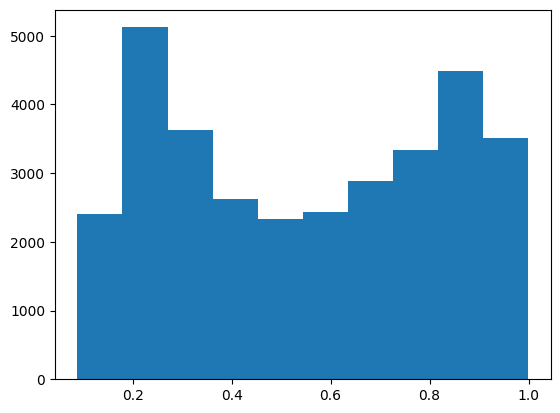

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  1761 | Count:  7728 | Corr:  0.3359487
FeatID:  2033 | Count:  3092 | Corr:  0.90579
FeatID:  20459 | Count:  1068 | Corr:  0.29366788
FeatID:  609 | Count:  815 | Corr:  0.8708205
FeatID:  28285 | Count:  408 | Corr:  0.45722377
FeatID:  30498 | Count:  365 | Corr:  0.88033986
FeatID:  16393 | Count:  147 | Corr:  0.9570006
FeatID:  16716 | Count:  139 | Corr:  0.3129664
FeatID:  29073 | Count:  134 | Corr:  0.36357924
FeatID:  503 | Count:  127 | Corr:  0.9417399
FeatID:  1806 | Count:  125 | Corr:  0.34325507
FeatID:  13455 | Count:  93 | Corr:  0.32189804
FeatID:  3341 | Count:  92 | Corr:  0.17393845
FeatID:  25316 | Count:  88 | Corr:  0.922001
FeatID:  8676 | Count:  87 | Corr:  0.8956792
FeatID:  1217 | Count:  86 | Corr:  0.6154708
FeatID:  2749 | Count:  82 | Corr:  0.8474744
FeatID:  25866 | Count:  81 | Corr:  0.17376138
FeatID:  29801 | Count:  77 | Corr:  0.24012592
FeatID:  110 | Count:  73 | Corr:  0.19875927


## interpret

In [ ]:
sorted_feat_counts[0][0]

1761

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  1761


batchID: 55, Act = 1.01, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 5, Act = 0.91, Seq = " to nine months in jail. Eric Brazau"
batchID: 49, Act = 0.89, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 13, Act = 0.89, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 39, Act = 0.88, Seq = " August, police have said.\n\nThe 28"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 7728
Correlation: 0.799122154712677
Model A Feature:  1761


batchID: 55, Act = 1.01, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 5, Act = 0.91, Seq = " to nine months in jail. Eric Brazau"
batchID: 49, Act = 0.89, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 13, Act = 0.89, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 39, Act = 0.88, Seq = " August, police have said.\n\nThe 28"

Model B Feature:  32765


batchID: 37, Act = 5.02, Seq = " proposal occurs under dramatically different circumstances, the empirical 
literature"
batchID: 88, Act = 4.60, Seq = "“Absent exigent circumstances, not present here"
batchID: 89, Act = 1.71, Seq = "s most iconic arenas. It’s played"
batchID: 34, Act = 1.69, Seq = " virtually nothing but a lawsuit.\n\nThe Hig"
batchID: 54, Act = 1.69, Seq = "SHARE Gov. Scott Walker Friday named"

--------------------------------------------------
Count: 3092
Correlation: 0.7220042943954468
Model A Feature:  2033


batchID: 37, Act = 9.19, Seq = "Executive summary\n\nThis paper reviews"
batchID: 59, Act = 8.94, Seq = " Riot Jynx\n\nCheck out the"
batchID: 48, Act = 8.90, Seq = " Help Out New Pal China\n\nIsrael is a"
batchID: 82, Act = 8.53, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 88, Act = 8.51, Seq = " Print Mail Flipboard\n\nLibertarian"

Model B Feature:  32761


batchID: 78, Act = 1.39, Seq = " Dr David Kelly inquest\n\nFound in woods"
batchID: 82, Act = 1.32, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 57, Act = 1.28, Seq = " the protests in Hong Kong\n\nIn January,"
batchID: 11, Act = 1.28, Seq = "s buy drapes!\n\nAnd there’"
batchID: 34, Act = 1.26, Seq = " virtually nothing but a lawsuit.\n\nThe Hig"

--------------------------------------------------
Count: 1068
Correlation: 0.6074742674827576
Model A Feature:  20459


batchID: 46, Act = 3.37, Seq = "From WikiFur,"
batchID: 59, Act = 3.36, Seq = " Riot Jynx\n\nCheck out the"
batchID: 97, Act = 3.20, Seq = " approximately 07:13 a.m., the Co"
batchID: 59, Act = 3.15, Seq = "By Riot Jyn"
batchID: 96, Act = 3.12, Seq = "On a third-down"

Model B Feature:  32739


batchID: 46, Act = 3.18, Seq = "From WikiFur,"
batchID: 26, Act = 1.28, Seq = "light ($19.88 from Home Depot."
batchID: 93, Act = 1.23, Seq = " government or corporations, but from our citizenry."
batchID: 3, Act = 1.20, Seq = "BIGBANG is"
batchID: 97, Act = 1.11, Seq = "OTT, age 25, from North Bend, came"

--------------------------------------------------
Count: 815
Correlation: 0.5781995058059692
Model A Feature:  609


batchID: 93, Act = 22.57, Seq = "Corporations And Govern"
batchID: 86, Act = 20.94, Seq = "Recently, education reporter Jay"
batchID: 0, Act = 20.52, Seq = "Port-au-Prince"
batchID: 76, Act = 20.32, Seq = "JERUSALEM"
batchID: 48, Act = 20.17, Seq = "Israel Accused of Supp"

Model B Feature:  32582


batchID: 95, Act = 1.41, Seq = "ST. LOUIS"
batchID: 51, Act = 1.38, Seq = "NES has signed a"
batchID: 76, Act = 1.32, Seq = "JERUSALEM"
batchID: 16, Act = 1.32, Seq = "MOSCOW ("
batchID: 3, Act = 1.21, Seq = "BIGBANG is"

--------------------------------------------------
Count: 408
Correlation: 0.4441390633583069
Model A Feature:  28285


batchID: 13, Act = 3.15, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 33, Act = 3.07, Seq = " the course of four days. Here’s pre"
batchID: 49, Act = 3.00, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 5, Act = 2.98, Seq = " to nine months in jail. Eric Brazau"
batchID: 56, Act = 2.98, Seq = "’t know for sure. But the trackers"

Model B Feature:  32767


batchID: 98, Act = 1.39, Seq = "Ultra-loved"
batchID: 5, Act = 1.01, Seq = "razau had argued, Clements said in a"
batchID: 5, Act = 1.01, Seq = " and Sharia law, Clements said.\n"
batchID: 5, Act = 0.81, Seq = " and anger Muslims,” said Clements. The content"
batchID: 5, Act = 0.70, Seq = " little interest in debate,” Clements said. B"

--------------------------------------------------


## rmv junk

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?', '<|endoftext|>']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))
print("num unique feats after filt: ", len(list(set(filt_corr_ind_A))) )

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.47807780320366133
num feats after filt:  10925
num unique feats after filt:  5223


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.3871171146799667

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.0064374745377444266

In [ ]:
dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
rand_scores = shuffle_rand(6, weight_matrix_np[new_highest_correlations_indices_A],
                                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                            representational_similarity_analysis, shapereq_bool=True)
dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)

In [ ]:
dictscores

{'num_feat_kept': 10924,
 'mean_actv_corr_filt': 0.4465202316396274,
 'rsa_paired': 0.12302792145965037,
 'rsa_rand_mean': 0.00046771369581574473}

### interpret

In [ ]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  609 | Count:  333 | Corr:  0.8708205
FeatID:  110 | Count:  63 | Corr:  0.19875927
FeatID:  1806 | Count:  55 | Corr:  0.34325507
FeatID:  13455 | Count:  55 | Corr:  0.32189804
FeatID:  25316 | Count:  53 | Corr:  0.922001
FeatID:  8506 | Count:  49 | Corr:  0.16657093
FeatID:  27303 | Count:  48 | Corr:  0.7639943
FeatID:  30873 | Count:  47 | Corr:  0.8619683
FeatID:  29801 | Count:  40 | Corr:  0.24012592
FeatID:  18306 | Count:  39 | Corr:  0.67371523
FeatID:  9601 | Count:  38 | Corr:  0.33175275
FeatID:  27520 | Count:  27 | Corr:  0.4158885
FeatID:  29458 | Count:  25 | Corr:  0.7033388
FeatID:  32619 | Count:  25 | Corr:  0.4784851
FeatID:  28542 | Count:  25 | Corr:  0.26288226
FeatID:  10520 | Count:  25 | Corr:  0.94692373
FeatID:  21107 | Count:  24 | Corr:  0.23083074
FeatID:  23961 | Count:  23 | Corr:  0.44179696
FeatID:  7562 | Count:  23 | Corr:  0.8357538
FeatID:  1216 | Count:  23 | Corr:  0.7105029


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  609


batchID: 93, Act = 22.57, Seq = "Corporations And Govern"
batchID: 86, Act = 20.94, Seq = "Recently, education reporter Jay"
batchID: 0, Act = 20.52, Seq = "Port-au-Prince"
batchID: 76, Act = 20.32, Seq = "JERUSALEM"
batchID: 48, Act = 20.17, Seq = "Israel Accused of Supp"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 333
Correlation: 0.5781995058059692
Model A Feature:  609


batchID: 93, Act = 22.57, Seq = "Corporations And Govern"
batchID: 86, Act = 20.94, Seq = "Recently, education reporter Jay"
batchID: 0, Act = 20.52, Seq = "Port-au-Prince"
batchID: 76, Act = 20.32, Seq = "JERUSALEM"
batchID: 48, Act = 20.17, Seq = "Israel Accused of Supp"

Model B Feature:  32582


batchID: 95, Act = 1.41, Seq = "ST. LOUIS"
batchID: 51, Act = 1.38, Seq = "NES has signed a"
batchID: 76, Act = 1.32, Seq = "JERUSALEM"
batchID: 16, Act = 1.32, Seq = "MOSCOW ("
batchID: 3, Act = 1.21, Seq = "BIGBANG is"

--------------------------------------------------
Count: 63
Correlation: 0.30756109952926636
Model A Feature:  110


batchID: 86, Act = 5.40, Seq = " reading they do for homework and on their own."
batchID: 47, Act = 5.35, Seq = " in any of its cars and venture off into the"
batchID: 72, Act = 5.22, Seq = " people who oppose carding and street checks have cited"
batchID: 88, Act = 5.21, Seq = " law being hand cuffed and his two dogs killed"
batchID: 54, Act = 5.15, Seq = " law as it is written and the oath that I"

Model B Feature:  32658


batchID: 99, Act = 1.53, Seq = " the world spend hundreds of billions of dollars a year"
batchID: 99, Act = 1.34, Seq = " world spend hundreds of billions of dollars a year on"
batchID: 65, Act = 1.33, Seq = "i, Tapert and Campbell to chat about"
batchID: 8, Act = 1.26, Seq = " Sunday could have just been due to poor workmanship"
batchID: 65, Act = 1.15, Seq = "ation of the Evil Dead universe. They shared a"

--------------------------------------------------
Count: 55
Correlation: 0.7131339907646179
Model A Feature:  1806


batchID: 83, Act = 4.38, Seq = "Porter Airlines confirmed today"
batchID: 87, Act = 4.36, Seq = "Frazer Brown writes"
batchID: 19, Act = 4.36, Seq = "F ancy cars have"
batchID: 78, Act = 4.36, Seq = "Fingerprint riddle"
batchID: 22, Act = 4.28, Seq = "SAN FRANCIS"

Model B Feature:  32760


batchID: 16, Act = 1.35, Seq = "MOSCOW ("
batchID: 94, Act = 1.06, Seq = "Poland will sign ACT"
batchID: 76, Act = 0.84, Seq = "JERUSALEM"
batchID: 91, Act = 0.70, Seq = "Squeeze on consumer"
batchID: 22, Act = 0.70, Seq = "SAN FRANCIS"

--------------------------------------------------
Count: 55
Correlation: 0.18818028271198273
Model A Feature:  13455


batchID: 44, Act = 3.70, Seq = " School junior who’s trying to run for a"
batchID: 95, Act = 3.66, Seq = "outing,” he said of trying to pick the Under"
batchID: 66, Act = 3.57, Seq = ", but I’m trying to save time."
batchID: 55, Act = 3.45, Seq = " said. "You're trying to get local governments"
batchID: 2, Act = 3.44, Seq = " despite his 50 propaganda speeches trying to persuade us to"

Model B Feature:  32373


batchID: 54, Act = 0.55, Seq = " have no impact on that whatsoever," Kelly said."
batchID: 68, Act = 0.54, Seq = "Yes! Yes! Yes!,” she said,"
batchID: 2, Act = 0.44, Seq = " enough job getting the message out to the American people"
batchID: 8, Act = 0.43, Seq = " Sunday could have just been due to poor workmanship"
batchID: 53, Act = 0.42, Seq = "\nTension has been prevailing in the state since"

--------------------------------------------------
Count: 53
Correlation: 0.4139444828033447
Model A Feature:  25316


batchID: 93, Act = 1.63, Seq = "Corporations And Govern"
batchID: 60, Act = 1.42, Seq = "FILE - In this Dec"
batchID: 90, Act = 1.28, Seq = "Fact Buster\n\n"
batchID: 3, Act = 1.28, Seq = "BIGBANG is"
batchID: 37, Act = 1.26, Seq = "Executive summary\n\n"

Model B Feature:  32747


batchID: 98, Act = 1.34, Seq = "Ultra-loved"
batchID: 55, Act = 1.14, Seq = "Protesters take to"
batchID: 93, Act = 1.10, Seq = "Corporations And Govern"
batchID: 90, Act = 0.98, Seq = "Fact Buster\n\n"
batchID: 94, Act = 0.93, Seq = "Poland will sign ACT"

--------------------------------------------------


## rmv junk- include : and ` and ' and slash and brackets

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?', '<|endoftext|>',
              ':', '\', ''', '`', '(', ')', '[', ']', '{' ,'}', '/']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))
print("num unique feats after filt: ", len(list(set(filt_corr_ind_A))) )

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.48410029781919495
num feats after filt:  10409
num unique feats after filt:  5039


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.35998553919931175

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.011627617168806567

# res stream 2 v 4

In [ ]:
layerID = 2
layer_id_2 = 4

## get llm actvs

In [ ]:
with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layerID)

In [ ]:
with torch.inference_mode():
    outputs_2 = get_llm_actvs_batch(model_2, inputs, layer_id_2)

## load sae

In [ ]:
name = "EleutherAI/sae-pythia-70m-32k"
weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(name, layerID, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
name = "EleutherAI/sae-pythia-160m-32k"
weight_matrix_2, reshaped_activations_B, feature_acts_model_B = get_weights_and_acts(name, layer_id_2, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

## corrs

In [ ]:
dictscores = {}

In [ ]:
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.249908447265625


0.6040481330391003

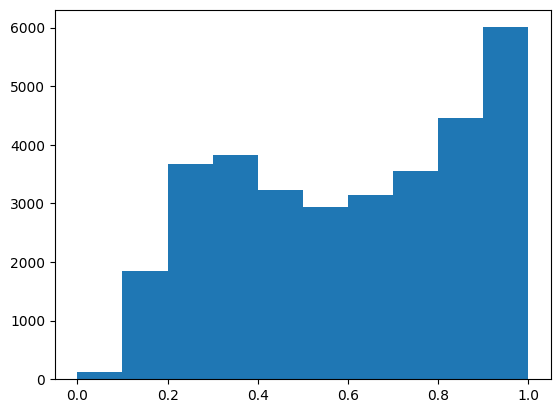

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  16337 | Count:  3380 | Corr:  0.85110193
FeatID:  2604 | Count:  2521 | Corr:  0.24802002
FeatID:  11415 | Count:  1156 | Corr:  0.37972695
FeatID:  21787 | Count:  1110 | Corr:  0.54125947
FeatID:  32352 | Count:  952 | Corr:  0.44031504
FeatID:  32697 | Count:  758 | Corr:  0.20359369
FeatID:  32565 | Count:  319 | Corr:  0.33579344
FeatID:  13328 | Count:  266 | Corr:  0.27263984
FeatID:  12313 | Count:  212 | Corr:  0.9039557
FeatID:  7318 | Count:  182 | Corr:  0.9493655
FeatID:  15282 | Count:  180 | Corr:  0.11466556
FeatID:  3128 | Count:  155 | Corr:  0.6534026
FeatID:  28639 | Count:  124 | Corr:  0.13871373
FeatID:  19100 | Count:  89 | Corr:  0.5631503
FeatID:  12813 | Count:  89 | Corr:  0.3685379
FeatID:  26566 | Count:  86 | Corr:  0.91879505
FeatID:  17535 | Count:  84 | Corr:  0.7522948
FeatID:  11049 | Count:  78 | Corr:  0.55598146
FeatID:  22809 | Count:  75 | Corr:  0.78058225
FeatID:  7120 | Count:  63 | Corr:  0.39637682


## interpret

In [ ]:
sorted_feat_counts[0][0]

16337

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  16337


batchID: 21, Act = 1.48, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 1.47, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 39, Act = 1.47, Seq = " August, police have said.\n\nThe 28"
batchID: 27, Act = 1.46, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 44, Act = 1.46, Seq = " tale of New Jersey politics. So it is only"

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 3380
Correlation: 0.4044768512248993
Model A Feature:  16337


batchID: 21, Act = 1.48, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 1.47, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 39, Act = 1.47, Seq = " August, police have said.\n\nThe 28"
batchID: 27, Act = 1.46, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 44, Act = 1.46, Seq = " tale of New Jersey politics. So it is only"

Model B Feature:  32757


batchID: 57, Act = 3.05, Seq = " Cindy Sui speaks to Taiwanese students holding"
batchID: 92, Act = 2.86, Seq = " alleges Trump knew Stone talked with WikiLeaks about"
batchID: 19, Act = 2.66, Seq = " find many articles online talking about what cars rappers"
batchID: 29, Act = 2.53, Seq = " she didn’t speak at last week’s"
batchID: 8, Act = 2.52, Seq = " "We can't talk about secret intelligence and things"

--------------------------------------------------
Count: 2521
Correlation: 0.5863062143325806
Model A Feature:  2604


batchID: 33, Act = 2.93, Seq = " the course of four days. Here’s pre"
batchID: 21, Act = 2.85, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 2.73, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 27, Act = 2.68, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 37, Act = 2.66, Seq = "Executive summary\n\nThis paper reviews"

Model B Feature:  32750


batchID: 62, Act = 4.26, Seq = " (because it makes you look cool). Today,"
batchID: 90, Act = 3.67, Seq = " found coffee can make you feel dehydrated?\n"
batchID: 47, Act = 2.02, Seq = " Uber Dubai app makes us sad By Mike Priest\n"
batchID: 90, Act = 1.73, Seq = " and tea can make you dehydrated because the caffeine"
batchID: 90, Act = 1.56, Seq = ": Does coffee make you dehydrated?\n\n"

--------------------------------------------------
Count: 1156
Correlation: 0.8483877778053284
Model A Feature:  11415


batchID: 13, Act = 1.53, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 33, Act = 1.42, Seq = " the course of four days. Here’s pre"
batchID: 56, Act = 1.41, Seq = "’t know for sure. But the trackers"
batchID: 97, Act = 1.36, Seq = " approximately 07:13 a.m., the Co"
batchID: 26, Act = 1.35, Seq = "” that costs $450. In this post I"

Model B Feature:  32728


batchID: 80, Act = 0.65, Seq = " China last Saturday (5.7.2014)"
batchID: 36, Act = 0.65, Seq = " to appear and observe proceedings. In the Marvel Universe"
batchID: 13, Act = 0.65, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 34, Act = 0.65, Seq = " virtually nothing but a lawsuit.\n\nThe Hig"
batchID: 96, Act = 0.64, Seq = " sacked quarterback Matt Ryan. Well, he tagged"

--------------------------------------------------
Count: 1110
Correlation: 0.9147319793701172
Model A Feature:  21787


batchID: 37, Act = 3.90, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 2.78, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 56, Act = 2.66, Seq = "’t know for sure. But the trackers"
batchID: 72, Act = 2.56, Seq = " his phone, when Coun. Matthew Green was stopped"
batchID: 77, Act = 2.54, Seq = " is over 7 years old\n\nMajor rights holders"

Model B Feature:  32759


batchID: 48, Act = 1.45, Seq = "Israel Accused of Supp"
batchID: 98, Act = 1.01, Seq = "Ultra-loved"
batchID: 67, Act = 0.81, Seq = "No. 1 - Retired"
batchID: 23, Act = 0.81, Seq = "Introduction\n\nOn Feb."
batchID: 8, Act = 0.79, Seq = " Korean leader Kim Jong Un. AP Images / Business"

--------------------------------------------------
Count: 952
Correlation: 0.9636811017990112
Model A Feature:  32352


batchID: 37, Act = 1.73, Seq = "Executive summary\n\nThis paper reviews"
batchID: 33, Act = 1.37, Seq = " the course of four days. Here’s pre"
batchID: 69, Act = 1.37, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 27, Act = 1.28, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 49, Act = 1.28, Seq = " arm prepared for minor surgery. (Print by Abraham"

Model B Feature:  32729


batchID: 30, Act = 2.67, Seq = " will show up for Ms. Sandberg’s"
batchID: 2, Act = 2.64, Seq = " the views of Townhall.com.\n\n"
batchID: 36, Act = 2.63, Seq = " to appear and observe proceedings. In the Marvel Universe"
batchID: 80, Act = 2.63, Seq = " China last Saturday (5.7.2014)"
batchID: 50, Act = 2.61, Seq = " more restrictive gun control laws. However, eight years"

--------------------------------------------------


## rmv junk

In [ ]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?', '<|endoftext|>']
            #   ':', '\', ''', '`', '(', ')', '[', ']', '{' ,'}', '/']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))
print("num unique feats after filt: ", len(list(set(filt_corr_ind_A))) )

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.450780901383311
num feats after filt:  11205
num unique feats after filt:  5051


In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.4703579009774438

In [ ]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [ ]:
sum(rand_scores) / len(rand_scores)

0.004665665952812674

In [ ]:
dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
rand_scores = shuffle_rand(1, weight_matrix_np[new_highest_correlations_indices_A],
                                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                            representational_similarity_analysis, shapereq_bool=True)
dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)

In [ ]:
dictscores

{'num_feat_kept': 11193,
 'mean_actv_corr_filt': 0.5515105849995452,
 'rsa_paired': 0.13234964566405152,
 'rsa_rand_mean': 0.00017505578455585162}

### interpret

In [ ]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  17535 | Count:  74 | Corr:  0.7522948
FeatID:  10852 | Count:  41 | Corr:  0.18062213
FeatID:  1172 | Count:  39 | Corr:  0.8029338
FeatID:  17879 | Count:  38 | Corr:  0.37323916
FeatID:  13295 | Count:  37 | Corr:  0.5249274
FeatID:  32582 | Count:  34 | Corr:  0.27099898
FeatID:  24529 | Count:  34 | Corr:  0.9284366
FeatID:  13230 | Count:  32 | Corr:  0.37025338
FeatID:  6091 | Count:  29 | Corr:  0.22553346
FeatID:  16277 | Count:  28 | Corr:  0.6464657
FeatID:  22376 | Count:  25 | Corr:  0.7434717
FeatID:  31952 | Count:  24 | Corr:  0.9211584
FeatID:  16442 | Count:  23 | Corr:  0.9617677
FeatID:  16799 | Count:  22 | Corr:  0.36746803
FeatID:  1516 | Count:  20 | Corr:  0.87002945
FeatID:  2440 | Count:  20 | Corr:  0.86680925
FeatID:  7291 | Count:  20 | Corr:  0.86009103
FeatID:  28071 | Count:  19 | Corr:  0.47139153
FeatID:  26051 | Count:  19 | Corr:  0.5161452
FeatID:  31098 | Count:  19 | Corr:  0.5493466


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons
num_display = 10

counter = 0
for feature_idx_A, feature_idx_B in zip(new_highest_correlations_indices_A, new_highest_correlations_indices_B):
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

    counter += 1
    if counter == num_display:
        break

Count: 952
Correlation: 0.6500524878501892
Model A Feature:  2344


batchID: 87, Act = 0.89, Seq = "**.\n\nContacting him on Twitter the same"
batchID: 11, Act = 0.76, Seq = "s Polltracker has him ahead by just over"
batchID: 17, Act = 0.75, Seq = " off the big run makes him deserving of a"
batchID: 3, Act = 0.68, Seq = " lost their minds – including myself. In fact,"
batchID: 45, Act = 0.64, Seq = " the win probabilities derived from them to peer into the"

Model B Feature:  0


batchID: 83, Act = 1.81, Seq = " Bombardier, and ushers in a change"
batchID: 36, Act = 1.79, Seq = " In the new DC Universe ushered in by the"
batchID: 56, Act = 1.53, Seq = " But the trackers, themselves, have turned in"
batchID: 29, Act = 1.41, Seq = " to say. You tell me,” Trump said."
batchID: 11, Act = 1.34, Seq = "s Polltracker has him ahead by just over"

--------------------------------------------------
Count: 952
Correlation: 0.6371020674705505
Model A Feature:  146


batchID: 8, Act = 4.20, Seq = " failed a whopping 88% of the time,"
batchID: 99, Act = 4.20, Seq = "pt secret, but 95% of the climate models"
batchID: 8, Act = 4.00, Seq = " its missile had a 13% failure rate, and"
batchID: 27, Act = 2.00, Seq = " with financials rising 4 percent to lead advancers"
batchID: 1, Act = 1.87, Seq = " difference of less than 1 percent, state officials held"

Model B Feature:  5


batchID: 99, Act = 4.36, Seq = "pt secret, but 95% of the climate models"
batchID: 8, Act = 3.59, Seq = " failed a whopping 88% of the time,"
batchID: 1, Act = 2.81, Seq = " In Missouri, with 100 percent of precincts"
batchID: 8, Act = 1.97, Seq = " its missile had a 13% failure rate, and"
batchID: 99, Act = 1.25, Seq = " secret, but 95% of the climate models we"

--------------------------------------------------
Count: 952
Correlation: 0.19584813714027405
Model A Feature:  27573


batchID: 16, Act = 1.03, Seq = " service was hit by Wannacry ransomware last"
batchID: 86, Act = 0.88, Seq = " then comes Night (Wiesel), A Child"
batchID: 54, Act = 0.75, Seq = " a little-known Waukesha lawyer with"
batchID: 16, Act = 0.66, Seq = "metov\n\nWannacry compromised the post"
batchID: 30, Act = 0.57, Seq = " adviser andOprah Winfrey?\n\n"

Model B Feature:  6


batchID: 48, Act = 5.10, Seq = "iel and Sheryl Wultz, that they would"
batchID: 54, Act = 4.79, Seq = " a little-known Waukesha lawyer with"
batchID: 39, Act = 4.75, Seq = " fatal incident, Bradley Wiggins, who by"
batchID: 16, Act = 4.44, Seq = "metov\n\nWannacry compromised the post"
batchID: 43, Act = 4.41, Seq = "urer.\n\nWaving Palestinian flags and shouting"

--------------------------------------------------
Count: 952
Correlation: 0.2145354449748993
Model A Feature:  17552


batchID: 86, Act = 5.74, Seq = " on the books kids in public schools from kindergarten"
batchID: 69, Act = 5.54, Seq = " after extensive campaigns to influence public opinion.\n\n"
batchID: 78, Act = 5.42, Seq = " held.\n\nThe public inquiry into his death"
batchID: 35, Act = 5.40, Seq = "cca, coalition director of public affairs, said in"
batchID: 54, Act = 5.38, Seq = ", but his name became public in June, when"

Model B Feature:  8


batchID: 54, Act = 1.56, Seq = ", but his name became public in June, when"
batchID: 81, Act = 1.42, Seq = " brief and ridiculous re-emergence of the Grand"
batchID: 66, Act = 1.28, Seq = "year-old said sheepishly as she made a"
batchID: 25, Act = 1.26, Seq = "bre tone at a press conference following the attacks."
batchID: 58, Act = 0.97, Seq = ", which included a press conference with the mayor,"

--------------------------------------------------
Count: 952
Correlation: 0.6184252500534058
Model A Feature:  9814


batchID: 26, Act = 2.98, Seq = "\nCut the flourescent shield to the"
batchID: 36, Act = 2.81, Seq = " hors d'oeuvres). In the DC"
batchID: 24, Act = 2.79, Seq = " 10 to 15 centimetres of snow Wednesday as"
batchID: 23, Act = 2.05, Seq = " that the Syrian Arab Red Crescent (SARC"
batchID: 23, Act = 2.01, Seq = " of the Syrian Arab Red Crescent (SARC"

Model B Feature:  9


batchID: 36, Act = 3.27, Seq = " hors d'oeuvres). In the DC"
batchID: 24, Act = 3.05, Seq = " 10 to 15 centimetres of snow Wednesday as"
batchID: 26, Act = 2.97, Seq = "\nCut the flourescent shield to the"
batchID: 79, Act = 1.02, Seq = " churches in his archdiocese to transition away from"
batchID: 32, Act = 0.82, Seq = " Jose.\n\nAdams has represented the United"

--------------------------------------------------
Count: 952
Correlation: 0.7180936336517334
Model A Feature:  31719


batchID: 14, Act = 4.21, Seq = "U)\n\nPokkén Tournament\n"
batchID: 4, Act = 0.82, Seq = " (it’s totally OK to order this as"
batchID: 68, Act = 0.74, Seq = "\n\nOn Monday, Oklahoma police made a decisive"
batchID: 4, Act = 0.63, Seq = "\nBut it’s OK. It’s"
batchID: 51, Act = 0.51, Seq = "building, Gdansk for the delivery of"

Model B Feature:  16


batchID: 14, Act = 6.66, Seq = "U)\n\nPokkén Tournament\n"
batchID: 4, Act = 2.31, Seq = "\nBut it’s OK. It’s"
batchID: 4, Act = 2.26, Seq = " (it’s totally OK to order this as"
batchID: 11, Act = 1.39, Seq = " three way race with Murkowski and Democrat Scott Mc"
batchID: 57, Act = 1.16, Seq = "ung, director of Hong Kong Trade Office in Tai"

--------------------------------------------------
Count: 952
Correlation: 0.2681841552257538
Model A Feature:  17535


batchID: 98, Act = 0.53, Seq = "Ultra-loved"
batchID: 15, Act = 0.18, Seq = "Ready to fight back?"
batchID: 2, Act = 0.09, Seq = " simply lamented that he hadn't done a good"
batchID: 53, Act = 0.07, Seq = "With no let-up"
batchID: 18, Act = 0.05, Seq = " for Cash.\n\nWin hands to increase your"

Model B Feature:  17


batchID: 98, Act = 1.14, Seq = "Ultra-loved"
batchID: 8, Act = 1.04, Seq = " program may be the shadowiest on earth, it"
batchID: 79, Act = 0.66, Seq = "\n\n“No Girl Scout cookie sales should occur"
batchID: 66, Act = 0.65, Seq = " America, from airplanes to offices. But places"
batchID: 66, Act = 0.63, Seq = " formal everywhere in America, from airplanes to offices"

--------------------------------------------------
Count: 952
Correlation: 0.30205151438713074
Model A Feature:  28348


batchID: 18, Act = 3.88, Seq = "About This Game Casino Blackjack 21 with"
batchID: 18, Act = 3.85, Seq = " Blackjack updates the Classic Casino Gambling Game with"
batchID: 18, Act = 2.66, Seq = "About This Game Casino Blackjack 21 with a TW"
batchID: 18, Act = 2.09, Seq = " Cash. Cheaters Blackjack updates the Classic Casino"
batchID: 18, Act = 1.97, Seq = " New Twist - Blackjack 21, Cheating"

Model B Feature:  18


batchID: 69, Act = 1.04, Seq = "ag Fire, an arson attack on the German"
batchID: 18, Act = 0.92, Seq = "About This Game Casino Blackjack 21 with"
batchID: 18, Act = 0.87, Seq = " New Twist - Blackjack 21, Cheating"
batchID: 82, Act = 0.85, Seq = " her skin, using photosynthesis to absorb air,"
batchID: 71, Act = 0.84, Seq = " hour southeast of Roanoke, Va.\n"

--------------------------------------------------
Count: 952
Correlation: 0.9160492420196533
Model A Feature:  2122


batchID: 47, Act = 3.53, Seq = " make it even easier for customers to book one of"
batchID: 6, Act = 3.36, Seq = ". Eduardo is asking customers to pay in cash"
batchID: 58, Act = 3.26, Seq = " for Salesforce employees and customers, and at night"
batchID: 91, Act = 1.11, Seq = "Squeeze on consumer spending is the worst"
batchID: 91, Act = 1.11, Seq = " per cent fall in real consumer spending per household between"

Model B Feature:  21


batchID: 47, Act = 6.21, Seq = " make it even easier for customers to book one of"
batchID: 6, Act = 6.03, Seq = ". Eduardo is asking customers to pay in cash"
batchID: 58, Act = 6.02, Seq = " for Salesforce employees and customers, and at night"
batchID: 97, Act = 0.84, Seq = " Reckless Driving complaint.\n\nThe"
batchID: 91, Act = 0.81, Seq = " per cent fall in real consumer spending per household between"

--------------------------------------------------
Count: 952
Correlation: 0.7379084825515747
Model A Feature:  26294


batchID: 85, Act = 1.80, Seq = " Readington Township pulled over Carmen Reategui"
batchID: 76, Act = 0.51, Seq = " him of undergoing small-arms training by radical Islam"
batchID: 3, Act = 0.42, Seq = " this larger-than-life Korean pop group perform"
batchID: 5, Act = 0.28, Seq = " Tuesday to nine months in jail. Eric Braz"
batchID: 39, Act = 0.27, Seq = " Park at 9.28pm on suspicion of causing"

Model B Feature:  22


batchID: 85, Act = 4.12, Seq = " Readington Township pulled over Carmen Reategui"
batchID: 46, Act = 0.87, Seq = " become two-thirds lycan, and lose his"
batchID: 59, Act = 0.85, Seq = " miisyou Sumino Kairosmith Sne"
batchID: 78, Act = 0.77, Seq = " such as his, no coroner’s in"
batchID: 46, Act = 0.67, Seq = "itten by a pure lycan, causing him to"

--------------------------------------------------


# res stream 2 v 3

In [35]:
layerID = 2
layer_id_2 = 3

## get llm actvs

In [36]:
with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layerID)

In [37]:
with torch.inference_mode():
    outputs_2 = get_llm_actvs_batch(model_2, inputs, layer_id_2)

## load sae

In [38]:
name = "EleutherAI/sae-pythia-70m-32k"
weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(name, layerID, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.2/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

In [39]:
name = "EleutherAI/sae-pythia-160m-32k"
weight_matrix_2, reshaped_activations_B, feature_acts_model_B = get_weights_and_acts(name, layer_id_2, outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.3/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

## corrs

In [40]:
dictscores = {}

In [41]:
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.16259765625


0.7650287390695212

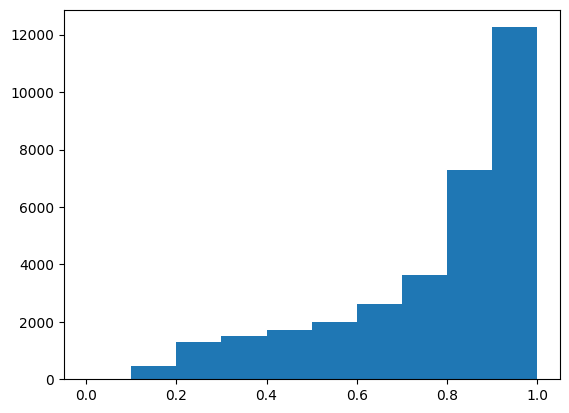

In [42]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [43]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  28639 | Count:  4099 | Corr:  0.98547137
FeatID:  13328 | Count:  1781 | Corr:  0.28227848
FeatID:  16722 | Count:  1435 | Corr:  0.34297282
FeatID:  4323 | Count:  1203 | Corr:  0.87814236
FeatID:  2604 | Count:  1167 | Corr:  0.9855025
FeatID:  3128 | Count:  1072 | Corr:  0.93982583
FeatID:  32697 | Count:  974 | Corr:  0.668959
FeatID:  18607 | Count:  773 | Corr:  0.84842217
FeatID:  7120 | Count:  748 | Corr:  0.87380177
FeatID:  7356 | Count:  645 | Corr:  0.9286852
FeatID:  21724 | Count:  547 | Corr:  0.37821218
FeatID:  22965 | Count:  503 | Corr:  0.9002086
FeatID:  24540 | Count:  495 | Corr:  0.92656267
FeatID:  16337 | Count:  474 | Corr:  0.23848653
FeatID:  29735 | Count:  412 | Corr:  0.3903279
FeatID:  8500 | Count:  392 | Corr:  0.18472259
FeatID:  739 | Count:  335 | Corr:  0.826419
FeatID:  32352 | Count:  327 | Corr:  0.83948725
FeatID:  13231 | Count:  282 | Corr:  0.20702247
FeatID:  29840 | Count:  250 | Corr:  0.90484065


## interpret

In [44]:
sorted_feat_counts[0][0]

28639

In [45]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  28639


batchID: 37, Act = 3.31, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 3.01, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 1, Act = 2.92, Seq = " a campaign rally in St. Louis on Saturday."
batchID: 95, Act = 2.92, Seq = "ST. LOUIS —"
batchID: 29, Act = 2.91, Seq = " mother of a fallen U.S. soldier of"

In [46]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 4099
Correlation: 0.8400758504867554
Model A Feature:  28639


batchID: 37, Act = 3.31, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 3.01, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 1, Act = 2.92, Seq = " a campaign rally in St. Louis on Saturday."
batchID: 95, Act = 2.92, Seq = "ST. LOUIS —"
batchID: 29, Act = 2.91, Seq = " mother of a fallen U.S. soldier of"

Model B Feature:  32765


batchID: 48, Act = 3.36, Seq = "Israel Accused of Supp"
batchID: 80, Act = 3.23, Seq = " on two additional plants in China, with investment of"
batchID: 80, Act = 3.15, Seq = " into account the fact that China's Prime Minister Li"
batchID: 48, Act = 3.09, Seq = " evidence that the Bank of China laundered money for"
batchID: 48, Act = 3.04, Seq = " implicating the Bank of China. Now, at"

--------------------------------------------------
Count: 1781
Correlation: 0.8352351784706116
Model A Feature:  13328


batchID: 37, Act = 2.36, Seq = "Executive summary\n\nThis paper reviews"
batchID: 21, Act = 2.14, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 2.07, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 69, Act = 2.03, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 27, Act = 1.95, Seq = " the New York Stock Exchange.\n\nThe Dow"

Model B Feature:  32752


batchID: 60, Act = 4.13, Seq = "reli's lawyer told the court his client won't"
batchID: 54, Act = 3.05, Seq = ", the start of the court's new term."
batchID: 12, Act = 1.85, Seq = "Attention! This news"
batchID: 5, Act = 1.72, Seq = "ages their religion,” Ontario court Judge S. Ford"
batchID: 54, Act = 1.59, Seq = " keeping in place the high court's 5-2"

--------------------------------------------------
Count: 1435
Correlation: 0.742122232913971
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  32746


batchID: 93, Act = 1.45, Seq = "Corporations And Govern"
batchID: 89, Act = 1.26, Seq = "While it might not have"
batchID: 14, Act = 1.26, Seq = "Get cool in-game"
batchID: 17, Act = 1.24, Seq = "Stanley “Boom"
batchID: 31, Act = 1.23, Seq = "Breaking News Emails"

--------------------------------------------------
Count: 1203
Correlation: 0.8814215064048767
Model A Feature:  4323


batchID: 37, Act = 2.70, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 2.31, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 93, Act = 2.25, Seq = "Corporations And Govern"
batchID: 1, Act = 2.23, Seq = " a campaign rally in St. Louis on Saturday."
batchID: 56, Act = 2.11, Seq = "’t know for sure. But the trackers"

Model B Feature:  32759


batchID: 93, Act = 3.08, Seq = "Corporations And Govern"
batchID: 1, Act = 2.88, Seq = "Former secretary of state Hillary"
batchID: 98, Act = 2.71, Seq = "Ultra-loved"
batchID: 36, Act = 2.64, Seq = "Whenever something momentous happens"
batchID: 84, Act = 2.58, Seq = "Last month, the Seattle"

--------------------------------------------------
Count: 1167
Correlation: 0.7014617323875427
Model A Feature:  2604


batchID: 33, Act = 2.93, Seq = " the course of four days. Here’s pre"
batchID: 21, Act = 2.85, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 2.73, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 27, Act = 2.68, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 37, Act = 2.66, Seq = "Executive summary\n\nThis paper reviews"

Model B Feature:  32754


batchID: 3, Act = 8.35, Seq = " innovates and defines the direction a genre takes."
batchID: 70, Act = 8.04, Seq = " the Canucks as a directionless failure are being"
batchID: 80, Act = 1.74, Seq = " China last Saturday (5.7.2014)"
batchID: 17, Act = 1.64, Seq = " three year career at Kentucky. Williams rushed for 1"
batchID: 26, Act = 1.63, Seq = "” that costs $450. In this post I"

--------------------------------------------------


## rmv junk

In [47]:
dictscores = {}
samp_m = 5

junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?', '<|endoftext|>']
            #   ':', '\', ''', '`', '(', ')', '[', ']', '{' ,'}', '/']

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
    if feat_B % 2000 == 0:
        print(feat_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
    top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_A_labels = [tok.replace(' ', '') for tok in top_A_labels]

    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
    top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])
    top_B_labels = [tok.replace(' ', '') for tok in top_B_labels]

    flag = True
    for junk in junk_words:
        if junk in top_A_labels or junk in top_B_labels:
            flag = False
            break
    if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
        filt_corr_ind_A.append(feat_A)
        filt_corr_ind_B.append(feat_B)

num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))
print("num unique feats after filt: ", len(list(set(filt_corr_ind_A))) )

new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
    val = highest_correlations_values_AB[ind_B]
    if val > 0.1:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

# print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
# print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)

dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
% unique:  0.4037721324095458
num feats after filt:  7794
num unique feats after filt:  3147


In [48]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.03347445752444601

In [49]:
num_feats = len(new_highest_correlations_indices_A)
num_runs = 3
rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                            svcca, shapereq_bool=True)

In [50]:
sum(rand_scores) / len(rand_scores)

0.01533240377849037

In [51]:
dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
rand_scores = shuffle_rand(1, weight_matrix_np[new_highest_correlations_indices_A],
                                            weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                            representational_similarity_analysis, shapereq_bool=True)
dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)

In [52]:
dictscores

{'num_feat_kept': 7794,
 'mean_actv_corr_filt': 0.6095156384967048,
 'rsa_paired': 0.04283112760966416,
 'rsa_rand_mean': 0.0003743312812536474}

### interpret

In [59]:
sorted_feat_counts = Counter(new_highest_correlations_indices_A).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1])
        #   "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  16722 | Count:  719
FeatID:  7356 | Count:  275
FeatID:  739 | Count:  236
FeatID:  13086 | Count:  109
FeatID:  13231 | Count:  108
FeatID:  14677 | Count:  83
FeatID:  19765 | Count:  73
FeatID:  15529 | Count:  69
FeatID:  9230 | Count:  44
FeatID:  30921 | Count:  44
FeatID:  17535 | Count:  41
FeatID:  5281 | Count:  40
FeatID:  28436 | Count:  36
FeatID:  13662 | Count:  34
FeatID:  137 | Count:  34
FeatID:  23058 | Count:  30
FeatID:  13295 | Count:  24
FeatID:  12268 | Count:  24
FeatID:  23351 | Count:  24
FeatID:  31035 | Count:  23


In [60]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]

feat_B_lst = [ind_B for ind_A, ind_B in zip(new_highest_correlations_indices_A, new_highest_correlations_indices_B)
                if ind_A == feature_idx_A]
for feature_idx_B in feat_B_lst[:5]:
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 108
Correlation: 0.8284560441970825
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  15


batchID: 10, Act = 3.78, Seq = "Story highlights Tyka Nelson"
batchID: 86, Act = 3.22, Seq = "Recently, education reporter Jay"
batchID: 98, Act = 2.93, Seq = "Ultra-loved"
batchID: 12, Act = 2.72, Seq = "Attention! This news"
batchID: 71, Act = 2.70, Seq = "2 Journalists Killed"

--------------------------------------------------
Count: 108
Correlation: 0.9012966752052307
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  62


batchID: 98, Act = 3.89, Seq = "Ultra-loved"
batchID: 93, Act = 3.56, Seq = "Corporations And Govern"
batchID: 12, Act = 3.30, Seq = "Attention! This news"
batchID: 86, Act = 3.01, Seq = "Recently, education reporter Jay"
batchID: 22, Act = 2.98, Seq = "SAN FRANCIS"

--------------------------------------------------
Count: 108
Correlation: 0.8954108953475952
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  163


batchID: 93, Act = 2.84, Seq = "Corporations And Govern"
batchID: 59, Act = 2.63, Seq = "By Riot Jyn"
batchID: 48, Act = 2.57, Seq = "Israel Accused of Supp"
batchID: 68, Act = 2.50, Seq = "In May 1997, 8"
batchID: 98, Act = 2.23, Seq = "Ultra-loved"

--------------------------------------------------
Count: 108
Correlation: 0.8245628476142883
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  197


batchID: 98, Act = 2.71, Seq = "Ultra-loved"
batchID: 11, Act = 2.35, Seq = "There’s measuring the"
batchID: 48, Act = 2.33, Seq = "Israel Accused of Supp"
batchID: 36, Act = 2.13, Seq = "Whenever something momentous happens"
batchID: 72, Act = 1.80, Seq = "He was a few blocks"

--------------------------------------------------
Count: 108
Correlation: 0.8874359726905823
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  311


batchID: 69, Act = 5.46, Seq = " Gunpowder Treason Plot, a failed assassination"
batchID: 69, Act = 5.03, Seq = ", police smashed a bomb plot on Monday that recalls"
batchID: 55, Act = 4.82, Seq = "Protesters take to"
batchID: 93, Act = 4.11, Seq = "Corporations And Govern"
batchID: 10, Act = 3.92, Seq = "Story highlights Tyka Nelson"

--------------------------------------------------


In [58]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_A, ind_B in zip(new_highest_correlations_indices_A, new_highest_correlations_indices_B)
                if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[-1]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 719
Correlation: 0.742122232913971
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  32746


batchID: 93, Act = 1.45, Seq = "Corporations And Govern"
batchID: 89, Act = 1.26, Seq = "While it might not have"
batchID: 14, Act = 1.26, Seq = "Get cool in-game"
batchID: 17, Act = 1.24, Seq = "Stanley “Boom"
batchID: 31, Act = 1.23, Seq = "Breaking News Emails"

--------------------------------------------------
Count: 275
Correlation: 0.5703779458999634
Model A Feature:  7356


batchID: 93, Act = 21.81, Seq = "Corporations And Govern"
batchID: 83, Act = 18.75, Seq = "Porter Airlines confirmed today"
batchID: 91, Act = 18.68, Seq = "Squeeze on consumer"
batchID: 22, Act = 18.68, Seq = "SAN FRANCIS"
batchID: 86, Act = 18.01, Seq = "Recently, education reporter Jay"

Model B Feature:  32695


batchID: 37, Act = 2.50, Seq = "Executive summary\n\n"
batchID: 98, Act = 2.14, Seq = "Ultra-loved"
batchID: 48, Act = 2.14, Seq = "Israel Accused of Supp"
batchID: 83, Act = 2.10, Seq = "Porter Airlines confirmed today"
batchID: 18, Act = 2.00, Seq = "About This Game Casino Black"

--------------------------------------------------
Count: 236
Correlation: 0.5593113899230957
Model A Feature:  739


batchID: 93, Act = 2.99, Seq = "Corporations And Govern"
batchID: 83, Act = 2.61, Seq = "Porter Airlines confirmed today"
batchID: 48, Act = 2.41, Seq = "Israel Accused of Supp"
batchID: 91, Act = 2.34, Seq = "Squeeze on consumer"
batchID: 22, Act = 2.34, Seq = "SAN FRANCIS"

Model B Feature:  32636


batchID: 48, Act = 2.40, Seq = "Israel Accused of Supp"
batchID: 3, Act = 1.72, Seq = "BIGBANG is"
batchID: 93, Act = 1.61, Seq = "Corporations And Govern"
batchID: 24, Act = 1.58, Seq = "Winter isn't done with"
batchID: 98, Act = 1.58, Seq = "Ultra-loved"

--------------------------------------------------
Count: 109
Correlation: 0.8454399704933167
Model A Feature:  13086


batchID: 93, Act = 1.61, Seq = "Corporations And Govern"
batchID: 60, Act = 1.54, Seq = "FILE - In this Dec"
batchID: 83, Act = 1.43, Seq = "Porter Airlines confirmed today"
batchID: 48, Act = 1.36, Seq = "Israel Accused of Supp"
batchID: 54, Act = 1.32, Seq = "SHARE Gov. Scott"

Model B Feature:  32720


batchID: 60, Act = 3.36, Seq = "FILE - In this Dec"
batchID: 5, Act = 3.23, Seq = "ORONTO STAR FILE PHOTO )\n"
batchID: 48, Act = 2.69, Seq = "Israel Accused of Supp"
batchID: 98, Act = 2.65, Seq = "Ultra-loved"
batchID: 37, Act = 2.51, Seq = "Executive summary\n\n"

--------------------------------------------------
Count: 108
Correlation: 0.6385205388069153
Model A Feature:  13231


batchID: 93, Act = 3.58, Seq = "Corporations And Govern"
batchID: 91, Act = 2.68, Seq = "Squeeze on consumer"
batchID: 22, Act = 2.68, Seq = "SAN FRANCIS"
batchID: 84, Act = 2.62, Seq = "Last month, the Seattle"
batchID: 83, Act = 2.55, Seq = "Porter Airlines confirmed today"

Model B Feature:  32548


batchID: 10, Act = 2.07, Seq = "Story highlights Tyka Nelson"
batchID: 17, Act = 1.94, Seq = "Stanley “Boom"
batchID: 89, Act = 1.46, Seq = "While it might not have"
batchID: 93, Act = 1.24, Seq = "Corporations And Govern"
batchID: 32, Act = 1.21, Seq = "New York Red Bulls Home"

--------------------------------------------------


In [57]:
feat_B_lst

[]

In [56]:
feature_idx_A

7356

In [54]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons
num_display = 10

counter = 0
for feature_idx_A, feature_idx_B in zip(new_highest_correlations_indices_A, new_highest_correlations_indices_B):
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

    counter += 1
    if counter == num_display:
        break

Count: 1167
Correlation: 0.5334004163742065
Model A Feature:  1961


batchID: 9, Act = 3.63, Seq = " then started work on an Aprilia SXV 550"
batchID: 35, Act = 3.41, Seq = "Mayadin), Syria, June 25 and 26,""
batchID: 76, Act = 3.27, Seq = "od, near Tel Aviv April 25, 2013."
batchID: 32, Act = 3.22, Seq = " made his MLS debut in April against San Jose."
batchID: 46, Act = 3.12, Seq = " and Fridays Launch date June 6, 2010 End"

Model B Feature:  0


batchID: 97, Act = 2.55, Seq = "On August 22, 2015,"
batchID: 5, Act = 1.44, Seq = " Ford Clements said in February, when he found"
batchID: 68, Act = 1.37, Seq = "’s backyard. In June, he agreed to"
batchID: 60, Act = 1.35, Seq = " last witness on Tuesday, July 25, 2017,"
batchID: 77, Act = 1.34, Seq = " giants and the government in November last year. The"

--------------------------------------------------
Count: 1167
Correlation: 0.257357120513916
Model A Feature:  18429


batchID: 32, Act = 0.91, Seq = " club sides based in Guadalajara, Club"
batchID: 32, Act = 0.84, Seq = " weekend for camp in Guadalajara, Mexico"
batchID: 32, Act = 0.74, Seq = " side from Chivas Guadalajara.\n"
batchID: 92, Act = 0.29, Seq = " Stone talked with WikiLeaks about DNC emails"
batchID: 63, Act = 0.29, Seq = " 1971 film version of Macbeth, the 1973 movie"

Model B Feature:  5


batchID: 32, Act = 1.43, Seq = " club sides based in Guadalajara, Club"
batchID: 32, Act = 1.36, Seq = " weekend for camp in Guadalajara, Mexico"
batchID: 32, Act = 1.21, Seq = ". ​\n\nSUBSCRIBE TO"
batchID: 96, Act = 1.10, Seq = " today.”\n\nMcKinley won over the"
batchID: 57, Act = 1.05, Seq = ".\n\n"Taiwan's democracy and"

--------------------------------------------------
Count: 1167
Correlation: 0.8692952394485474
Model A Feature:  24490


batchID: 6, Act = 6.34, Seq = " asking customers to pay in cash to avoid bank fees"
batchID: 30, Act = 6.33, Seq = "bound women, struggling with cash flow and child care"
batchID: 18, Act = 3.74, Seq = " West type showdown for Cash.\n\nWin"
batchID: 18, Act = 3.51, Seq = " against Cheaters to Win Cash. Cheaters Black"
batchID: 72, Act = 0.50, Seq = " oppose carding and street checks have cited as a"

Model B Feature:  7


batchID: 30, Act = 9.99, Seq = "bound women, struggling with cash flow and child care"
batchID: 6, Act = 9.51, Seq = " asking customers to pay in cash to avoid bank fees"
batchID: 18, Act = 6.63, Seq = " against Cheaters to Win Cash. Cheaters Black"
batchID: 18, Act = 6.57, Seq = " West type showdown for Cash.\n\nWin"
batchID: 82, Act = 2.39, Seq = "Massive spoilers in"

--------------------------------------------------
Count: 1167
Correlation: 0.7650878429412842
Model A Feature:  29111


batchID: 36, Act = 3.85, Seq = " he was at the Black Panther/Storm"
batchID: 66, Act = 1.12, Seq = ", knee-length running pants.\n\n“"
batchID: 3, Act = 0.26, Seq = "BIGBANG is one of those musical entities"
batchID: 11, Act = 0.25, Seq = " there’s measuring the drapes on a house"
batchID: 97, Act = 0.15, Seq = " identifiers as the vehicle was parked on the side of"

Model B Feature:  9


batchID: 36, Act = 0.30, Seq = " he was at the Black Panther/Storm"
batchID: 1, Act = 0.19, Seq = ", Sanders’s campaign manager, said the campaign"
batchID: 2, Act = 0.12, Seq = ". Nothing is ever his fault. Nothing will ever"
batchID: 15, Act = 0.03, Seq = ". Sign up for Take Action Now and we’"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"

--------------------------------------------------
Count: 1167
Correlation: 0.30412453413009644
Model A Feature:  4386


batchID: 34, Act = 2.02, Seq = " mortgage paid, a weeklong vacation and other gifts"
batchID: 73, Act = 1.36, Seq = ". Over his years-long tenure, this did"
batchID: 33, Act = 0.34, Seq = "The eight World Cup second round matches are spread over"
batchID: 58, Act = 0.01, Seq = " story. Local media was given their first opportunity to"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"

Model B Feature:  14


batchID: 34, Act = 1.12, Seq = " mortgage paid, a weeklong vacation and other gifts"
batchID: 73, Act = 0.94, Seq = ". Over his years-long tenure, this did"
batchID: 46, Act = 0.94, Seq = "s)\n\nFoxy Flavored Cookie"
batchID: 97, Act = 0.86, Seq = " disengaged contact with SCOTT and walked back towards"
batchID: 46, Act = 0.82, Seq = " edit ]\n\nFoxy Flavored Cookie"

--------------------------------------------------
Count: 1167
Correlation: 0.8284560441970825
Model A Feature:  16722


batchID: 93, Act = 3.64, Seq = "Corporations And Govern"
batchID: 91, Act = 3.47, Seq = "Squeeze on consumer"
batchID: 22, Act = 3.47, Seq = "SAN FRANCIS"
batchID: 86, Act = 3.28, Seq = "Recently, education reporter Jay"
batchID: 11, Act = 3.28, Seq = "There’s measuring the"

Model B Feature:  15


batchID: 10, Act = 3.78, Seq = "Story highlights Tyka Nelson"
batchID: 86, Act = 3.22, Seq = "Recently, education reporter Jay"
batchID: 98, Act = 2.93, Seq = "Ultra-loved"
batchID: 12, Act = 2.72, Seq = "Attention! This news"
batchID: 71, Act = 2.70, Seq = "2 Journalists Killed"

--------------------------------------------------
Count: 1167
Correlation: 0.3554321527481079
Model A Feature:  2805


batchID: 86, Act = 4.49, Seq = ") are held by one author, Stephanie Meyer —"
batchID: 12, Act = 4.23, Seq = " that the arbiters have authorised.\n\n"
batchID: 46, Act = 2.57, Seq = "avored Cookie\n\nAuthor(s) Thomas"
batchID: 21, Act = 2.43, Seq = " been released.\n\nAuthorities are trying to"
batchID: 55, Act = 1.94, Seq = " Scott has attempted to reauthorize the bill unsuccess"

Model B Feature:  21


batchID: 12, Act = 0.99, Seq = " that the arbiters have authorised.\n\n"
batchID: 86, Act = 0.99, Seq = ") are held by one author, Stephanie Meyer —"
batchID: 16, Act = 0.95, Seq = " of their computers and the creators of the virus demanding"
batchID: 32, Act = 0.83, Seq = " through the academy system before signing his first professional contract"
batchID: 36, Act = 0.83, Seq = " ushered in by the publisher's New 52 initiative"

--------------------------------------------------
Count: 1167
Correlation: 0.8339385390281677
Model A Feature:  7356


batchID: 93, Act = 21.81, Seq = "Corporations And Govern"
batchID: 83, Act = 18.75, Seq = "Porter Airlines confirmed today"
batchID: 91, Act = 18.68, Seq = "Squeeze on consumer"
batchID: 22, Act = 18.68, Seq = "SAN FRANCIS"
batchID: 86, Act = 18.01, Seq = "Recently, education reporter Jay"

Model B Feature:  29


batchID: 98, Act = 3.65, Seq = "Ultra-loved"
batchID: 48, Act = 2.86, Seq = "Israel Accused of Supp"
batchID: 86, Act = 2.28, Seq = "Recently, education reporter Jay"
batchID: 84, Act = 2.23, Seq = "Last month, the Seattle"
batchID: 20, Act = 2.22, Seq = "Refined mansion tax proposal"

--------------------------------------------------
Count: 1167
Correlation: 0.3782811760902405
Model A Feature:  5130


batchID: 80, Act = 3.07, Seq = " small package if you take into account the fact that"
batchID: 78, Act = 2.47, Seq = " of lying to take Britain into the Iraq war."
batchID: 71, Act = 2.34, Seq = " wound when he was taken into custody by Virginia State"
batchID: 60, Act = 2.32, Seq = " New York after being taken into custody following a securities"
batchID: 93, Act = 1.61, Seq = "Corporations And Govern"

Model B Feature:  35


batchID: 78, Act = 1.13, Seq = " of lying to take Britain into the Iraq war."
batchID: 34, Act = 1.12, Seq = " take the Higgins family into their home. The"
batchID: 59, Act = 1.11, Seq = "ino Kairosmith SneakyStyL He"
batchID: 80, Act = 0.99, Seq = " small package if you take into account the fact that"
batchID: 60, Act = 0.87, Seq = " New York after being taken into custody following a securities"

--------------------------------------------------
Count: 1167
Correlation: 0.9437028169631958
Model A Feature:  19765


batchID: 93, Act = 1.59, Seq = "Corporations And Govern"
batchID: 91, Act = 1.57, Seq = "Squeeze on consumer"
batchID: 22, Act = 1.57, Seq = "SAN FRANCIS"
batchID: 54, Act = 1.56, Seq = "SHARE Gov. Scott"
batchID: 86, Act = 1.52, Seq = "Recently, education reporter Jay"

Model B Feature:  36


batchID: 93, Act = 2.81, Seq = "Corporations And Govern"
batchID: 82, Act = 2.60, Seq = "Massive spoilers in"
batchID: 66, Act = 2.51, Seq = "As Ann Cabiness stood"
batchID: 28, Act = 2.51, Seq = "As President Barack Obama begins"
batchID: 36, Act = 2.48, Seq = "Whenever something momentous happens"

--------------------------------------------------
